In [1]:
# use seastar Kernel on adrien local laptop

# import os
import xarray as xr
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs # => to add in Seastar env
import seastar
from seastar.utils.tools import dotdict, lin2db
from seastar.performance import scene_generation

from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares

# from seastar.gmfs.doppler import *

In [2]:
SciReC_simu = '../../../workStations/seastar/scripts/SciReC_simu/'

# 1/ Baseline 4 beams: 4base_4AC15_35: Sqt: 3%, 5cm/s; Mid: 4%, 40cm/s

In [3]:
nickname = '4base'

In [4]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV40_MHNKp04RSV40_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [5]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [6]:
level2

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 4, input_wdir: 24, Ambiguities: 4,
                          fun_variables: 8, extrema: 2)
Coordinates:
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'MidH' 'Aft'
    fun_variables        (Observables, Antenna) int64 0 1 2 3 4 5 6 7
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'HH' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/21)
    x                    (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    active_mask          (input_wdir, Ambiguities, x_variables, across, along) int64 ...
    grad                 (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    fun                  (input_wdir, Ambiguities, Observables, Antenna, across, along) float64 ...
    jac                  (input_wdir, Ambiguities, fun_variables, x_variables, across, along) float64 ...
    x0                   (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    ...                   ...
    x_scale              (input_wdir, x_variables, across, along) float64 7.0...
    bounds               (input_wdir, extrema, x_variables, across, along) int64 ...
    u                    (input_wdir, Ambiguities, across, along) float64 -0....
    v                    (input_wdir, Ambiguities, across, along) float64 -4....
    c_u                  (input_wdir, Ambiguities, across, along) float64 0.4...
    c_v                  (input_wdir, Ambiguities, across, along) float64 -0....
Attributes:
    inst:     ../instruments/inst_4base_4AC15_35_011x_SNKp03RSV05_MVNKp04RSV4...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV40...
    level1:   ../level1s/level1_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV...

In [7]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [8]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 4, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'MidH' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'HH' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_4base_4AC15_35_011x_SNKp03RSV05_MVNKp04RSV4...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV40...
    level1:   ../level1s/level1_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV...

In [9]:
err = level2b - truth
err['flag'] = level2b.cost > 4

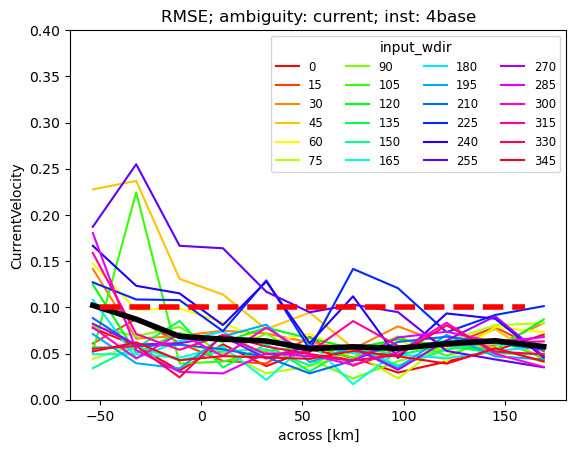

In [10]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

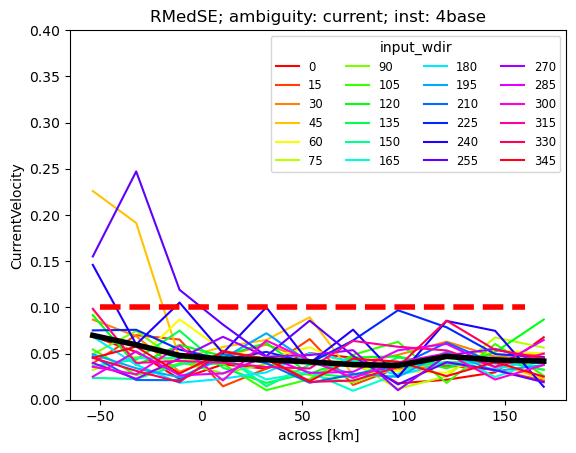

In [11]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMcdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

Text(0.5, 1.0, 'RMSE; ambiguity: current; inst: 4base')

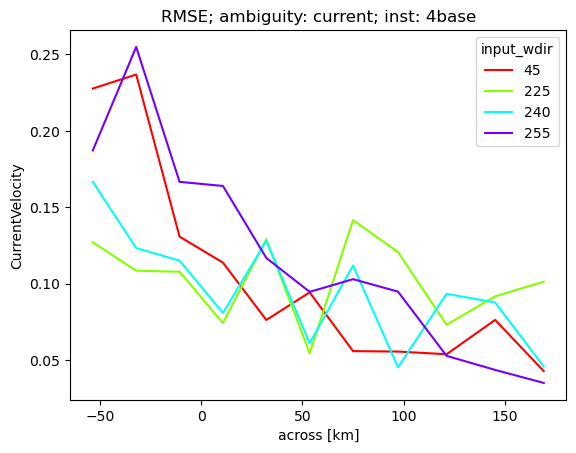

In [10]:
fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,5))
ax.set_prop_cycle("color", cmap)
np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
    .sel(input_wdir=[45, 225, 240, 255])\
    .sel(ambiguity_names='current')\
    .plot(hue='input_wdir',)# add_legend=False)
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)

Text(0.5, 1.03, 'Current; inst: 4base')

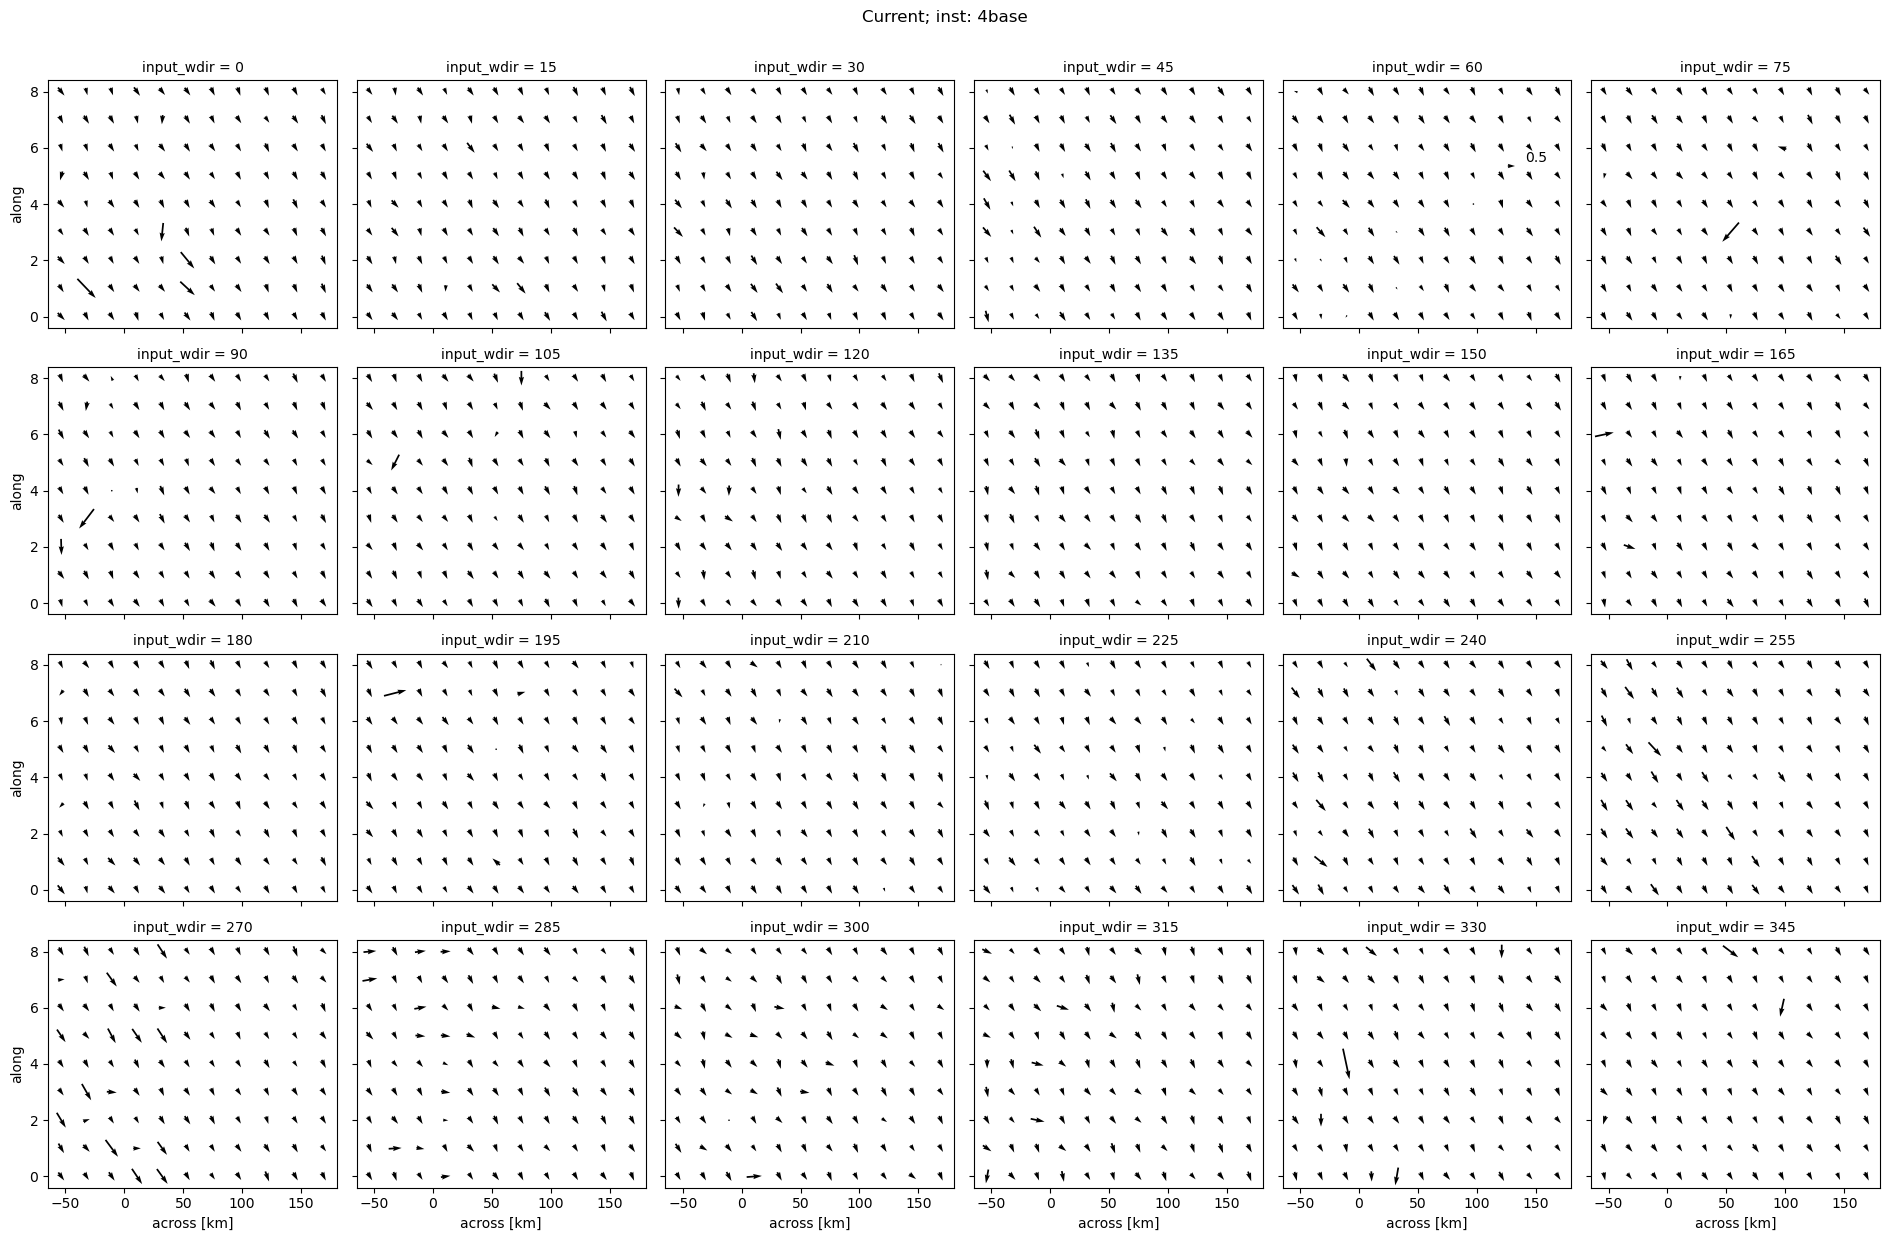

In [11]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 4base')

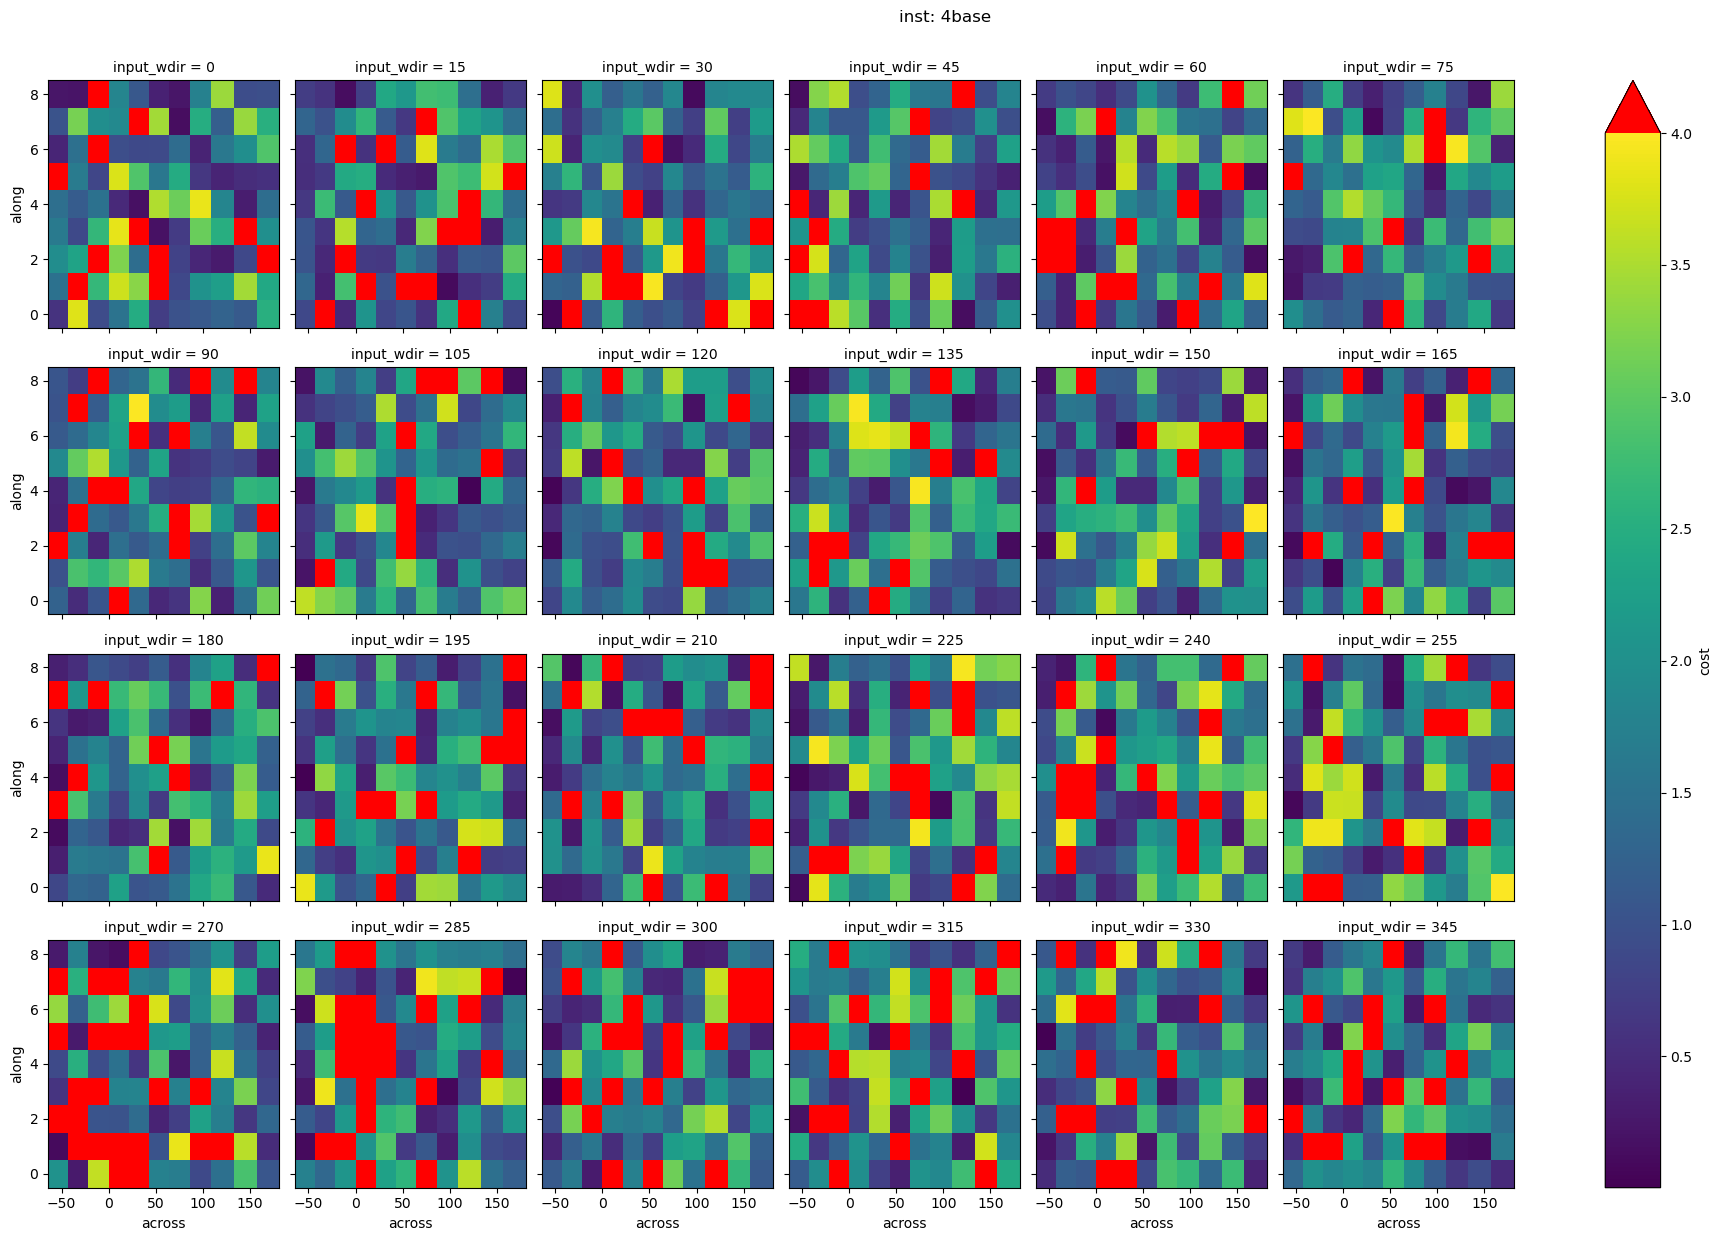

In [12]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=4, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_13494/3517965512.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im)
/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_13494/3517965512.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cbar.cmap.set_over('red')


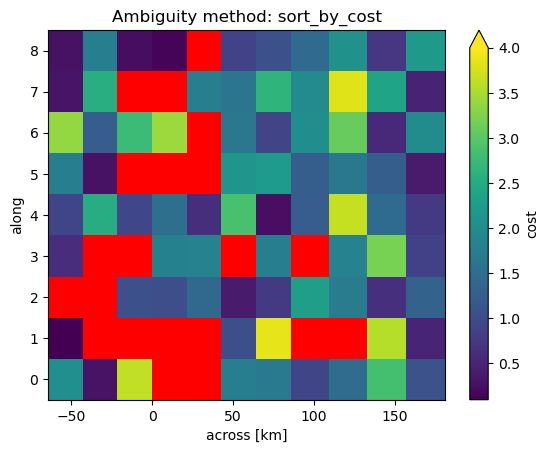

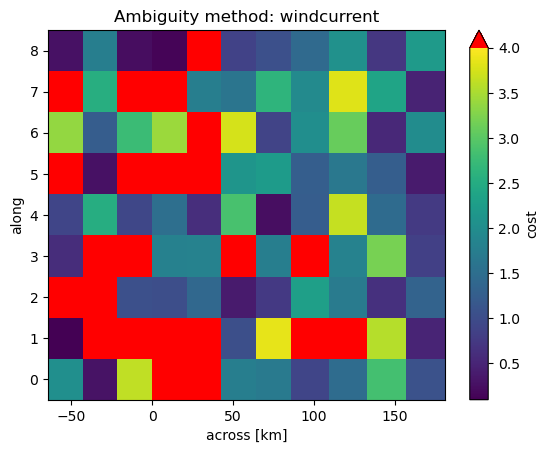

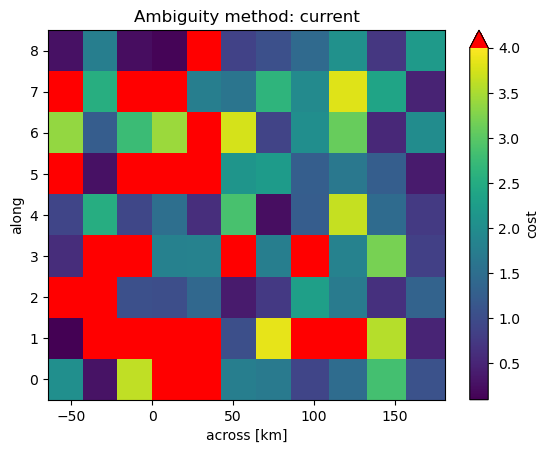

In [13]:
for amb in level2b.ambiguity_names.data:
    plt.figure()
    im = level2b.cost.sel(input_wdir=270).sel(ambiguity_names=amb).plot(x='across', vmax=4)
    cbar = fig.colorbar(im)
    cbar.cmap.set_over('red')
    plt.title('Ambiguity method: ' + amb)

# 2/ Baseline 4 beams but 20cm/s noise on mid: 4base_4AC15_35: Sqt: 3%, 5cm/s; Mid: 4%, 20cm/s

In [14]:
nickname = '4base_mid20cm/s'

In [15]:
input_wdir_list = np.arange(0,360,45)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV20_MHNKp04RSV20_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [16]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [17]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [18]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 4, input_wdir: 8, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'MidH' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'HH' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 45 90 135 180 225 270 315
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_4base_4AC15_35_011x_SNKp03RSV05_MVNKp04RSV2...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV20...
    level1:   ../level1s/level1_4base_4AC15_35_011x009_SNKp03RSV05_MVNKp04RSV...

In [19]:
err = level2b - truth
err['flag'] = level2b.cost > 4

Text(0.5, 1.0, 'RMSE; ambiguity: current; inst: 4base_mid20cm/s')

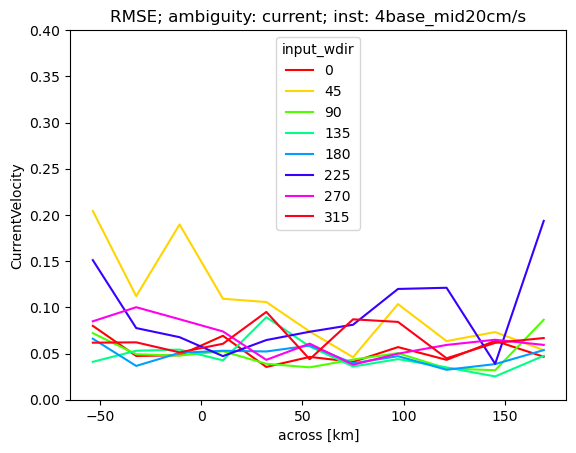

In [21]:
fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
    .sel(ambiguity_names='current')\
    .plot(hue='input_wdir',)# add_legend=False)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)

Text(0.5, 1.03, 'Current; inst: 4base_mid20cm/s')

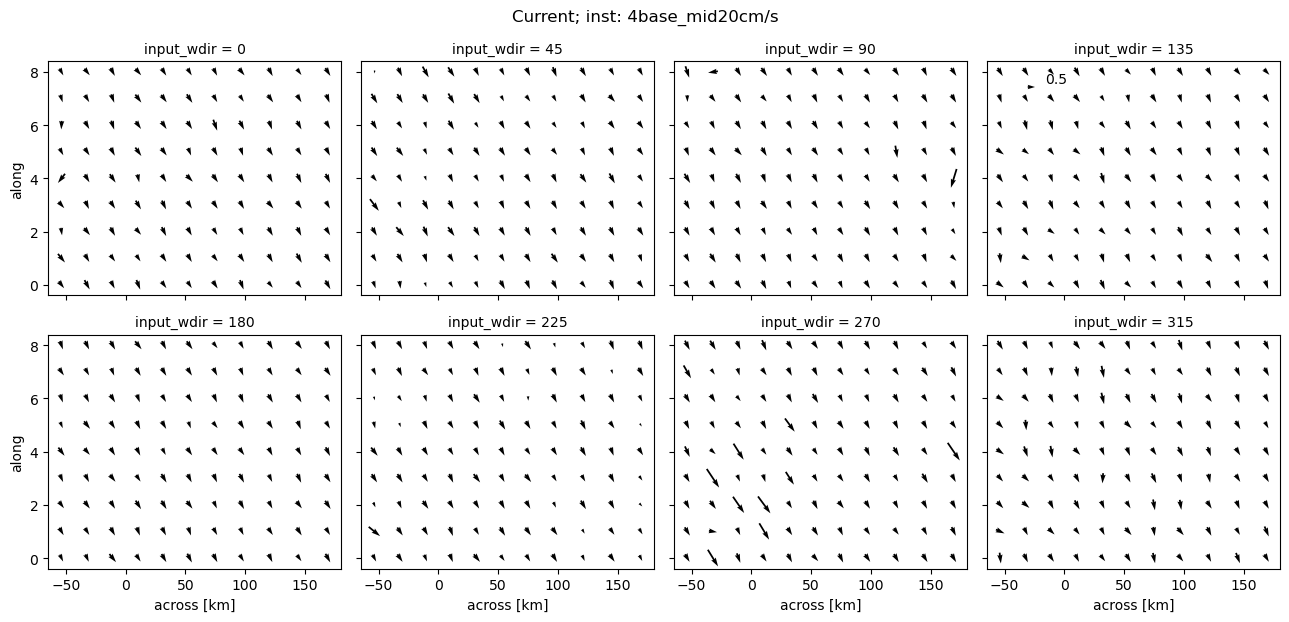

In [69]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=4, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'Wind; inst: 4base_mid20cm/s')

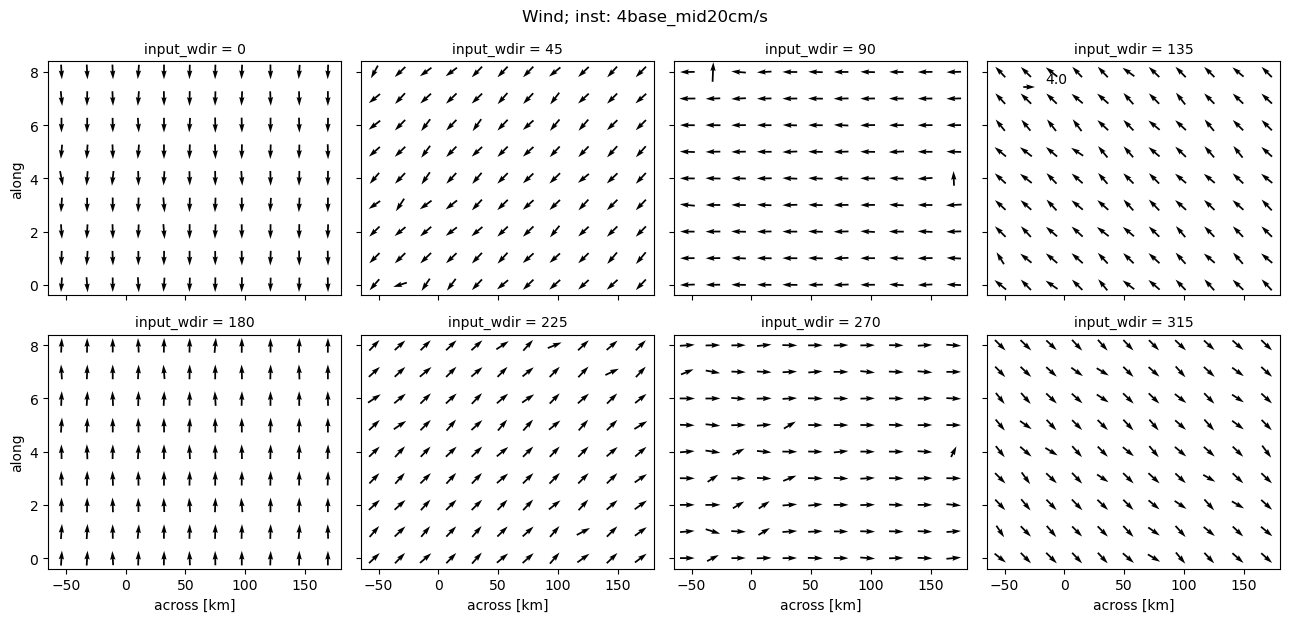

In [70]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='WindU',
    v='WindV',
    col='input_wdir', col_wrap=4, scale=100,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Wind' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 4base_mid20cm/s')

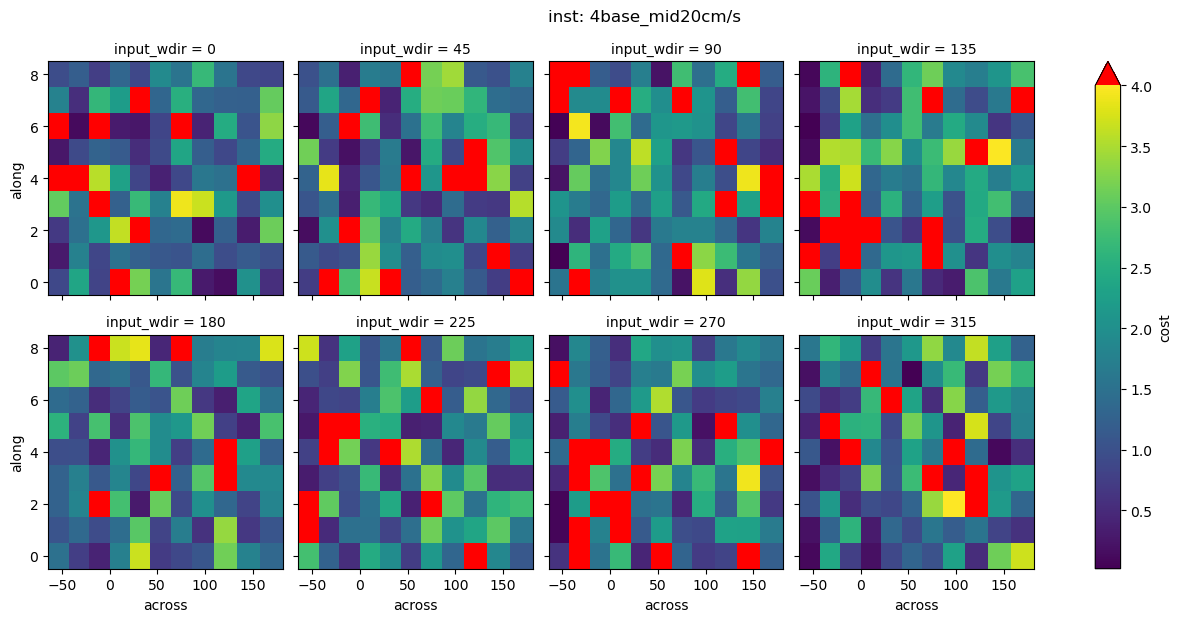

In [71]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=4, cmap=cmap,
         col='input_wdir', col_wrap=4, )
plt.suptitle('inst: ' + nickname, y=1.03)

/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_1907/3517965512.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im)
/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_1907/3517965512.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cbar.cmap.set_over('red')


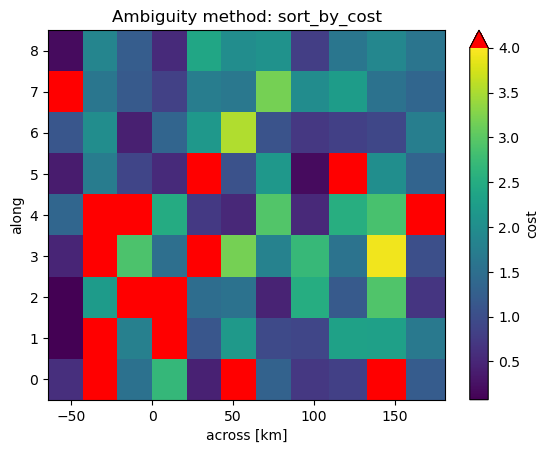

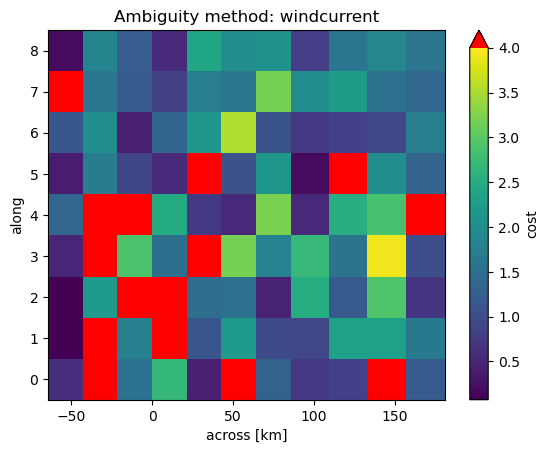

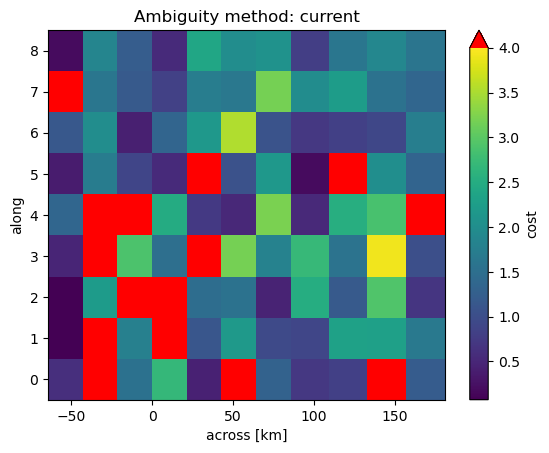

In [72]:
for amb in level2b.ambiguity_names.data:
    plt.figure()
    im = level2b.cost.sel(input_wdir=270).sel(ambiguity_names=amb).plot(x='across', vmax=4)
    cbar = fig.colorbar(im)
    cbar.cmap.set_over('red')
    plt.title('Ambiguity method: ' + amb)

Text(0.5, 1.0, 'Wind @270°; inst: 4base_mid20cm/s')

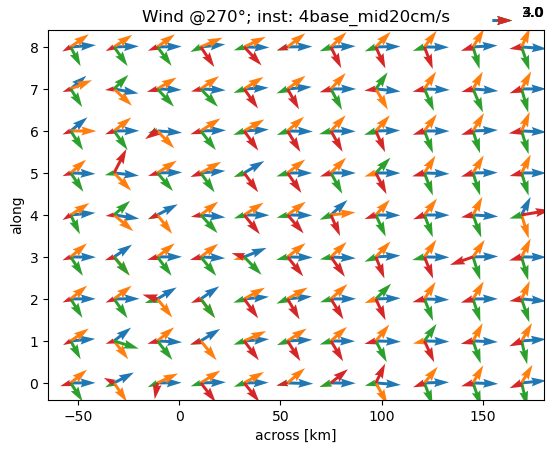

In [73]:
for ii in level2.Ambiguities.data:
    level2.sel(input_wdir=270).sel(Ambiguities=ii).plot.quiver(
        x='across',
        y='along',
        u='u',
        v='v',
        angles='uv',
        color='C'+str(ii), scale=100,
        pivot='tail',
    )
plt.title('Wind @270°' + '; inst: ' + nickname)

Text(0.5, 1.0, 'Current with wdir@270°; inst: 4base_mid20cm/s')

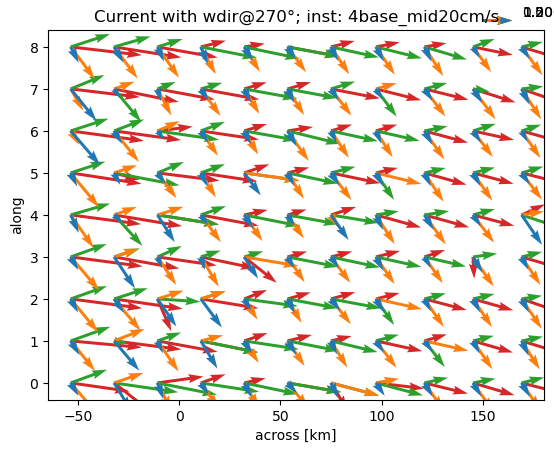

In [74]:
for ii in np.flip(level2.Ambiguities.data):
    level2.sel(input_wdir=270).sel(Ambiguities=ii).plot.quiver(
        x='across',
        y='along',
        u='c_u',
        v='c_v',
        angles='uv',
        color='C'+str(ii), scale=20,
        pivot='tail',
    )
plt.title('Current with wdir@270°' + '; inst: ' + nickname)

# 3/ 3 beams (no HH) otherwise same as baseline: 3base_3AC15_35: Sqt: 3%, 5cm/s; Mid: 4%, 40cm/s

In [12]:
nickname = '3base'

In [13]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV40_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [14]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [15]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [16]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 3, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV05_MVNKp04RSV4...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV40...
    level1:   ../level1s/level1_3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV...

Text(0.5, 1.03, 'Current; inst: 3base')

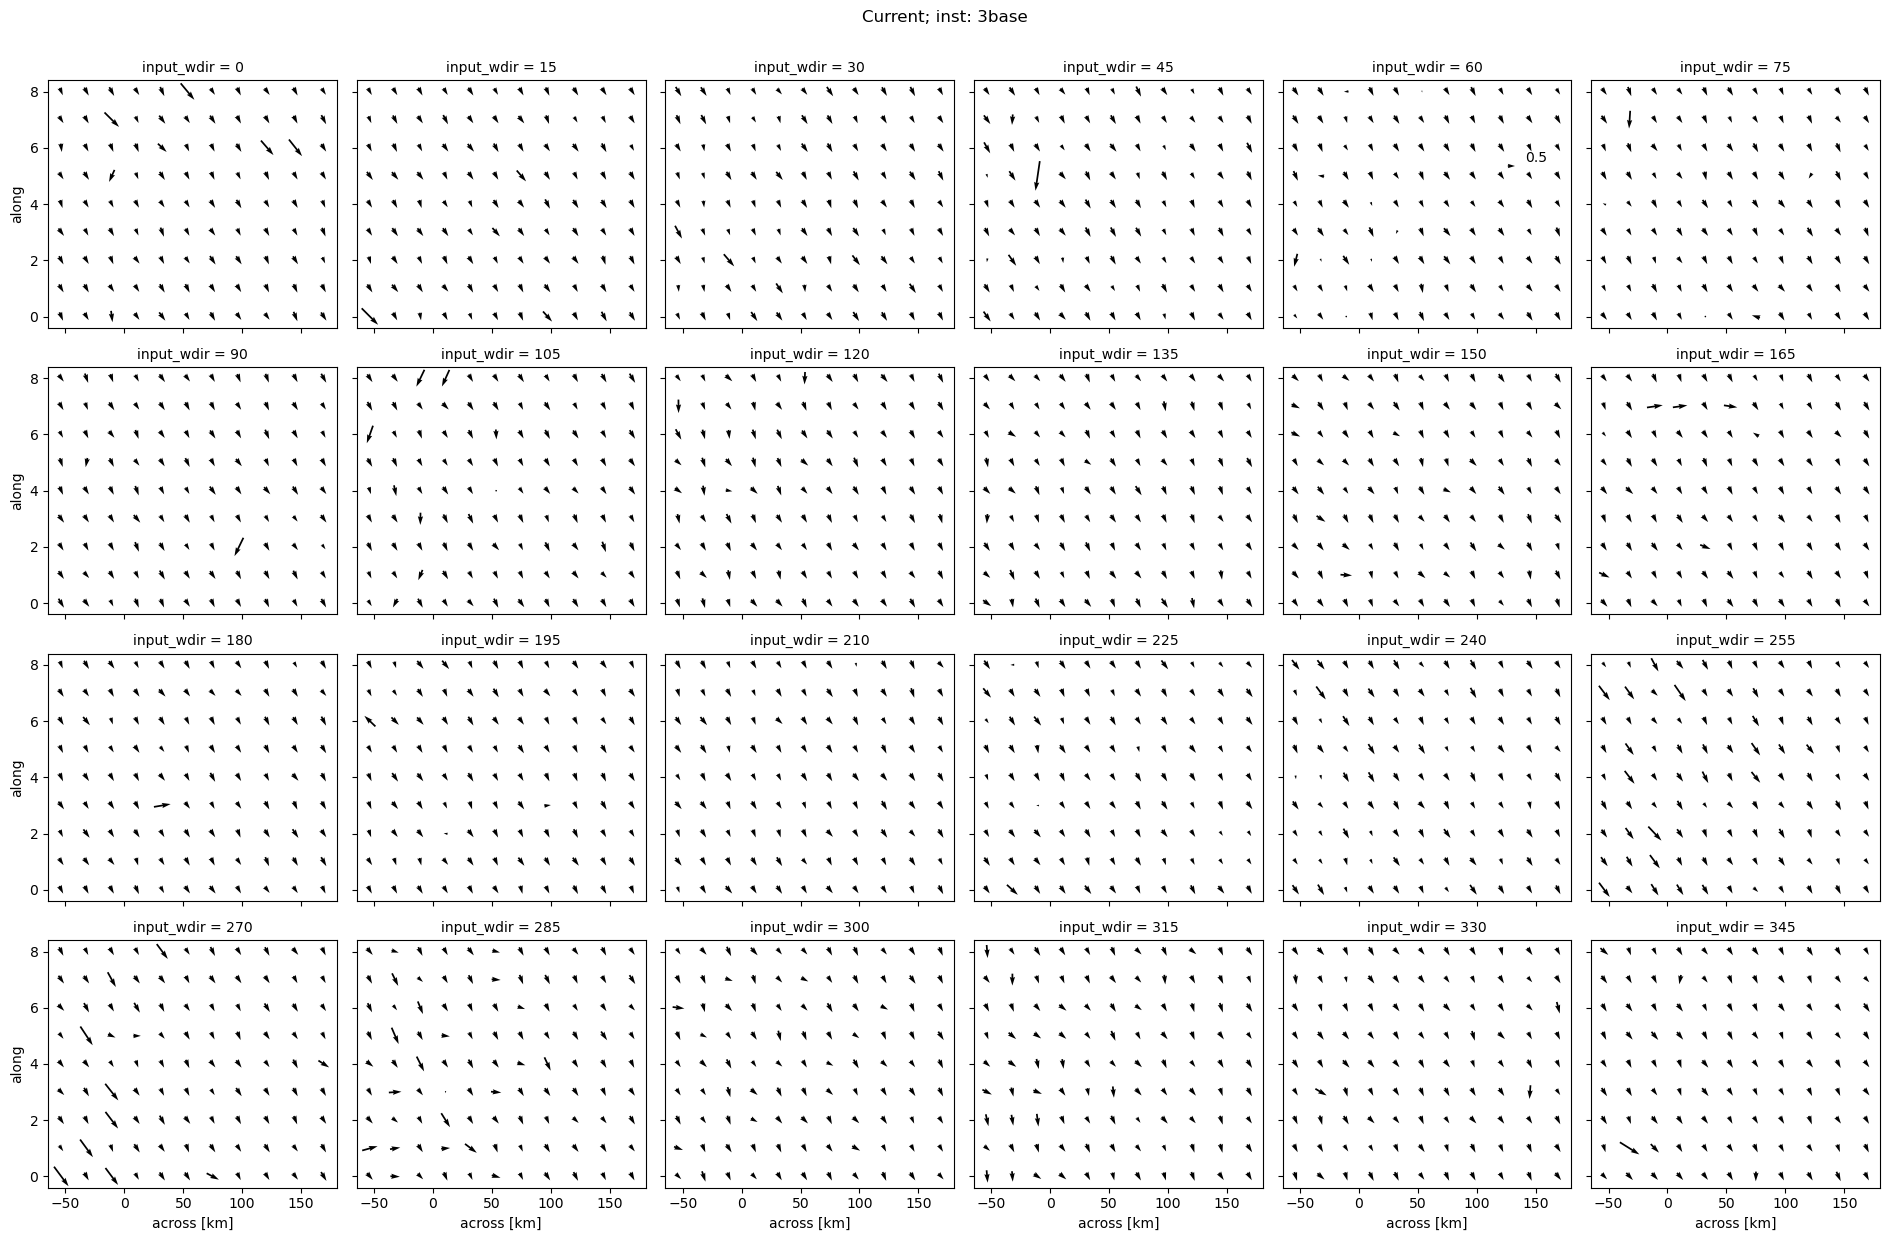

In [17]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 3base')

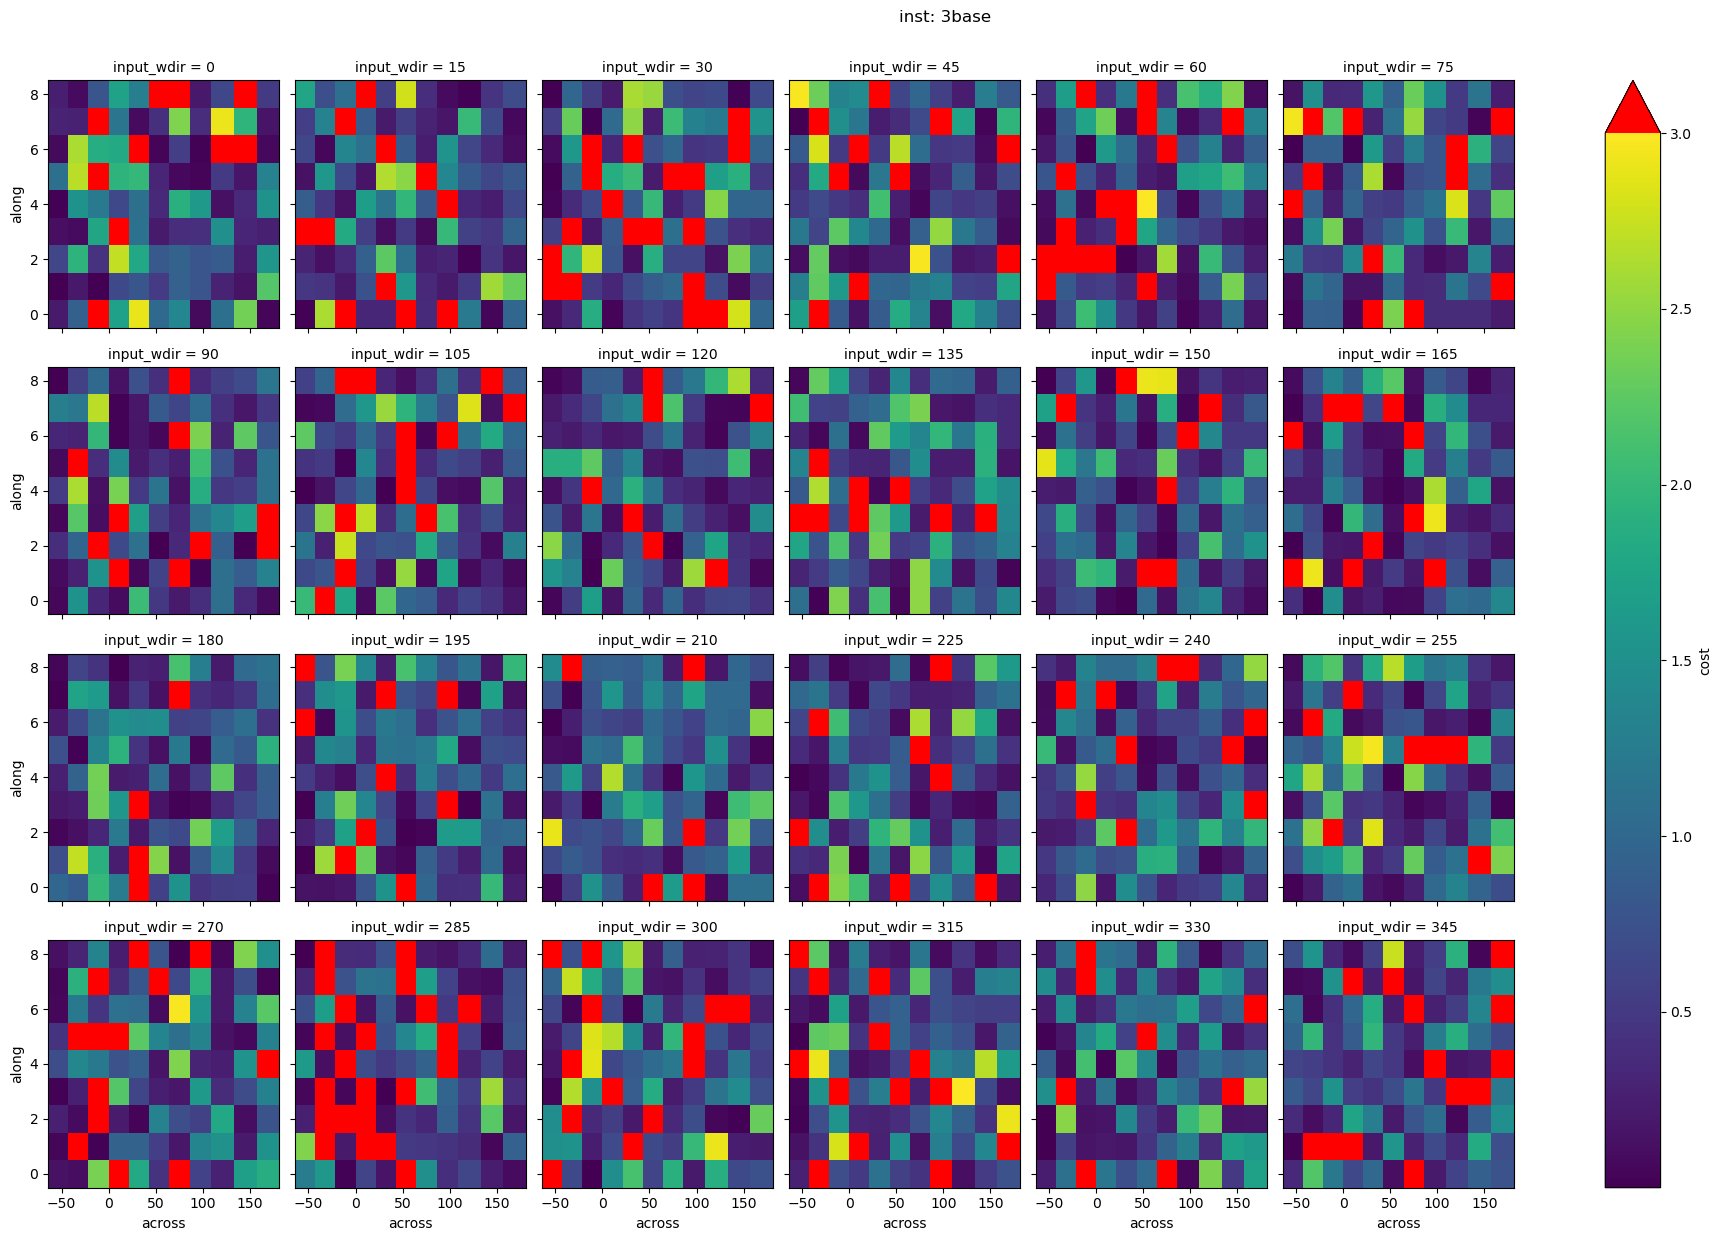

In [18]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=3, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

In [19]:
err = level2b - truth
err['flag'] = level2b.cost > 3

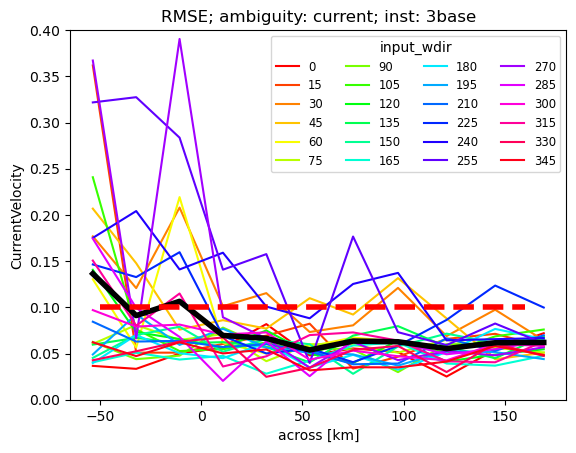

In [20]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

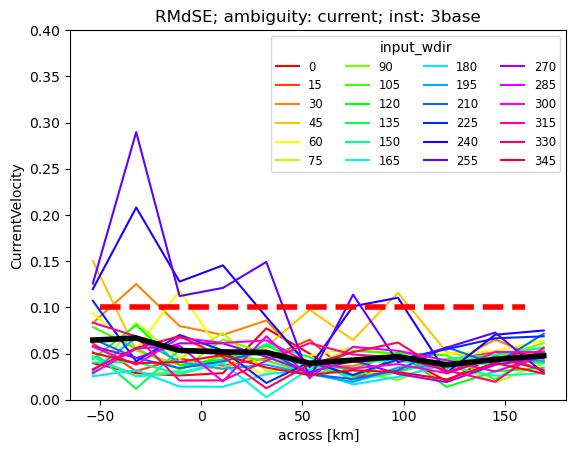

In [22]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# 4/ 3 beams (no HH, broadside VV=80cm/s) otherwise same as baseline: 3base_3AC15_35: Sqt: 3%, 5cm/s; Mid: 4%, 80cm/s

In [23]:
nickname = '3base_mid80cm/s'

In [24]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV80_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [25]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [26]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [27]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 3, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV05_MVNKp04RSV8...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV80...
    level1:   ../level1s/level1_3base_3AC15_35_011x009_SNKp03RSV05_MVNKp04RSV...

Text(0.5, 1.03, 'Current; inst: 3base_mid80cm/s')

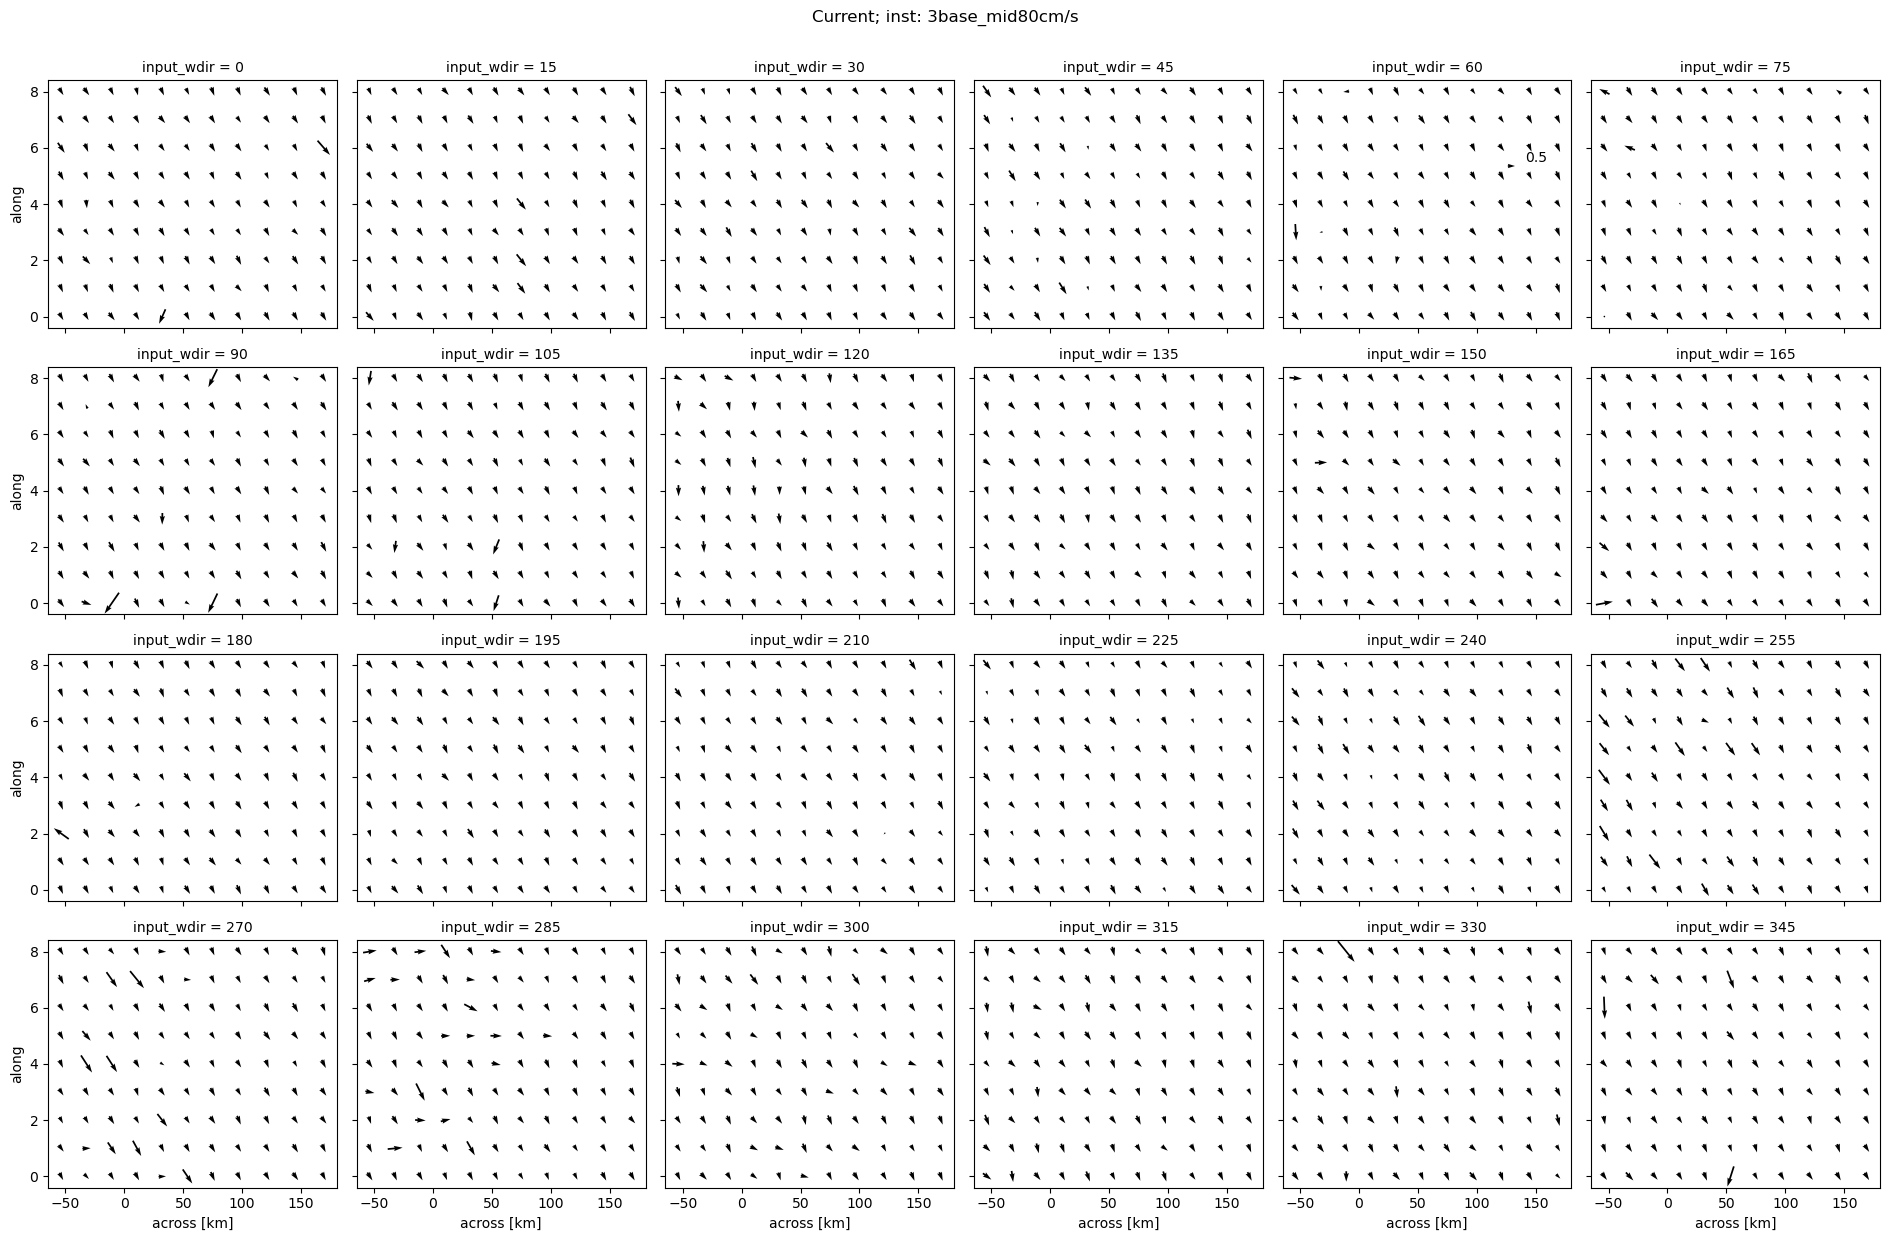

In [28]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 3base_mid80cm/s')

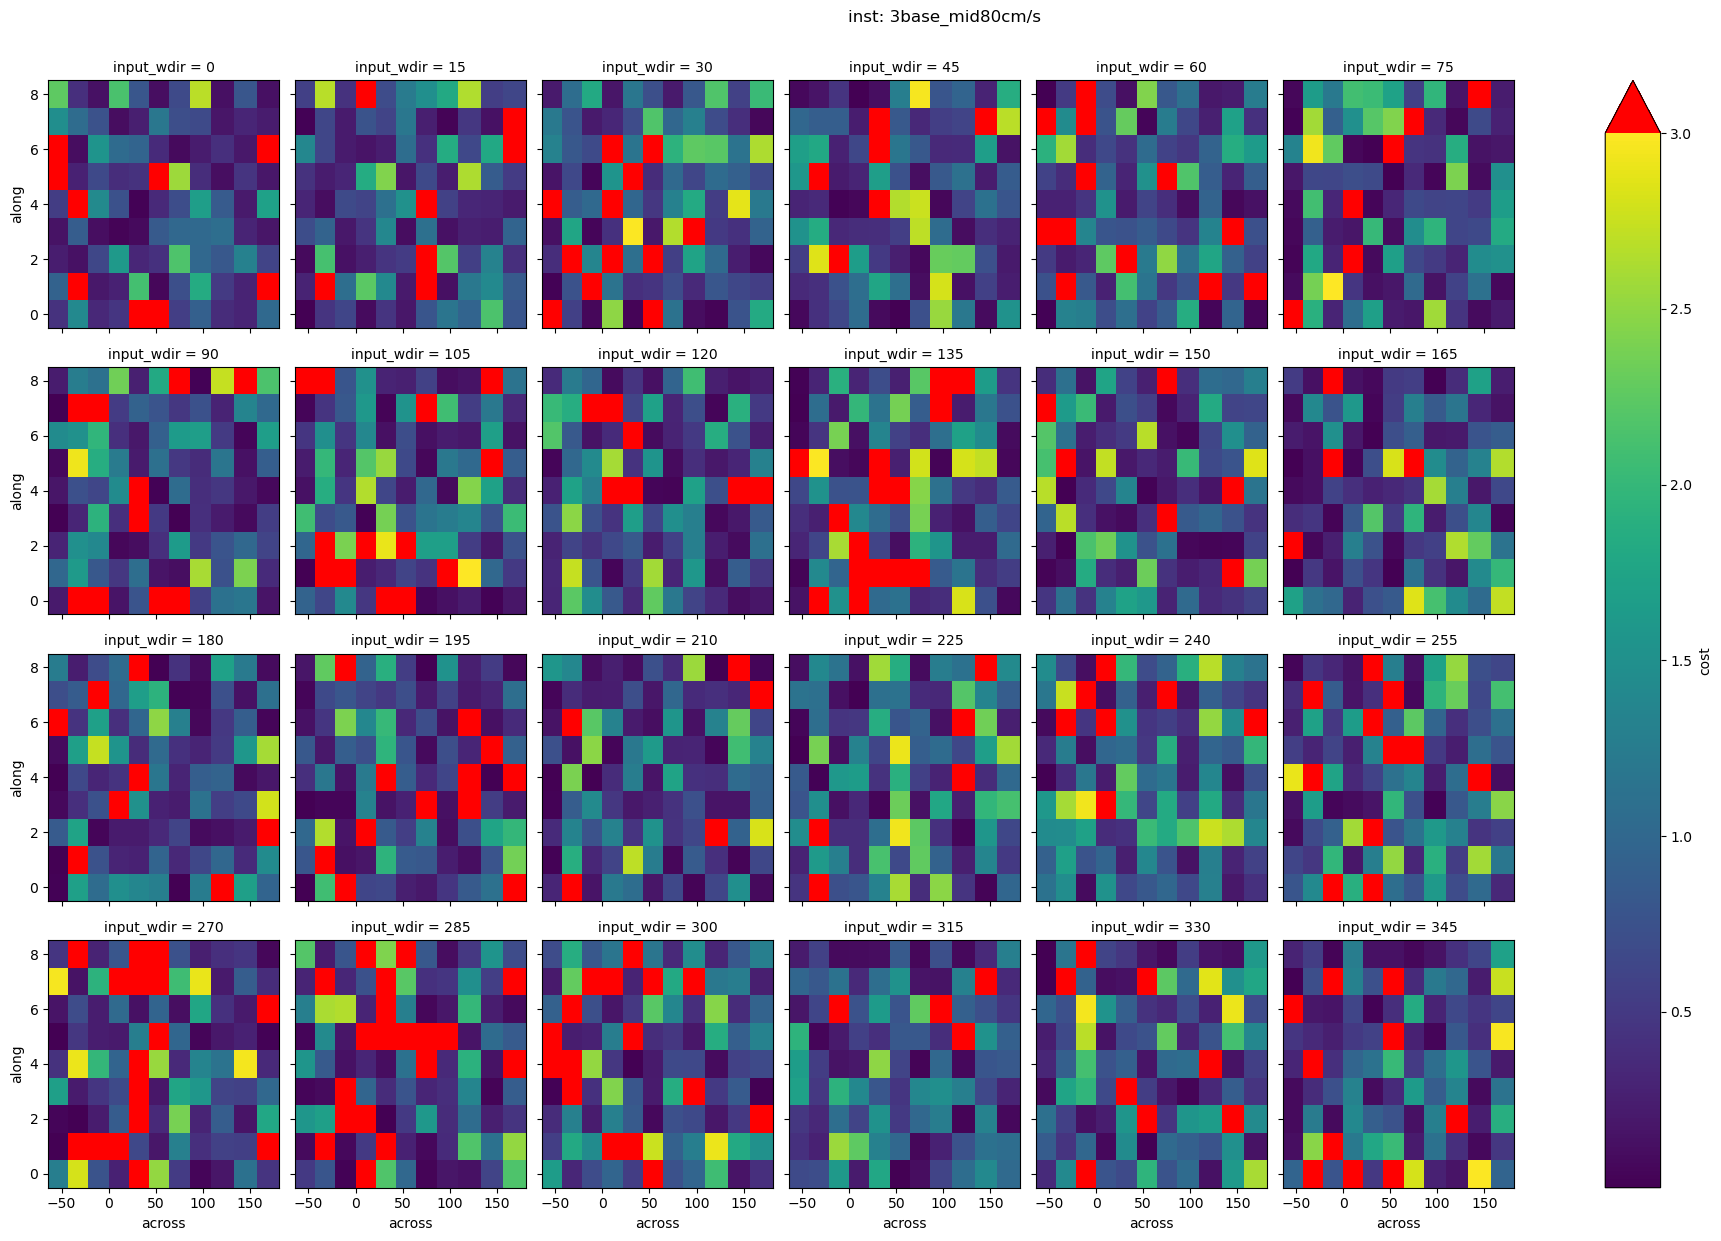

In [29]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=3, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

In [30]:
err = level2b - truth
err['flag'] = level2b.cost > 3

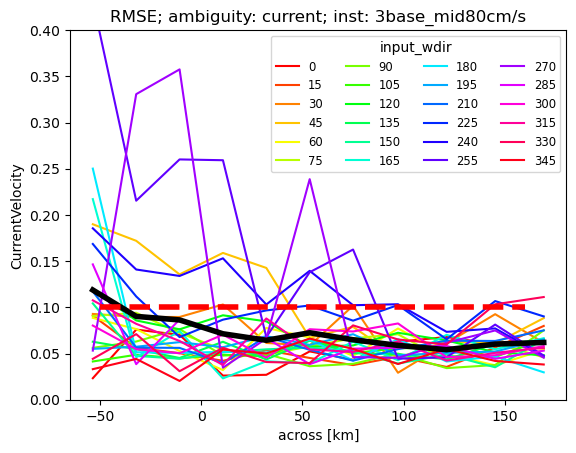

In [31]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

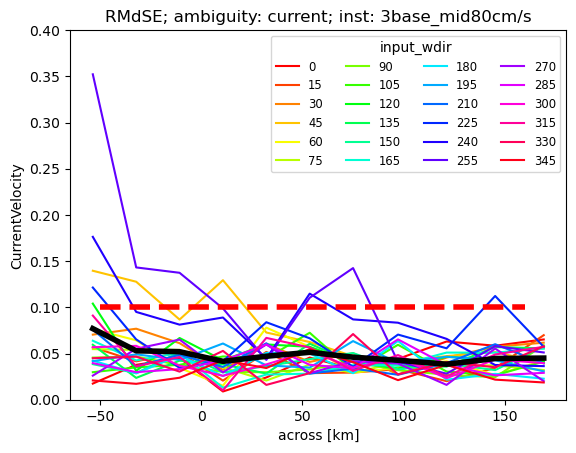

In [32]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# 5/ 3 beams (no HH, Squint VV=7cm/s) otherwise same as baseline: 3base_3AC15_35: Sqt: 3%, 7cm/s; Mid: 4%, 40cm/s

In [33]:
nickname = '3base_sqt7cm/s'

In [34]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '3base_3AC15_35_011x009_SNKp03RSV07_MVNKp04RSV40_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [35]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [36]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [37]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 3, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSV4...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x009_SNKp03RSV07_MVNKp04RSV40...
    level1:   ../level1s/level1_3base_3AC15_35_011x009_SNKp03RSV07_MVNKp04RSV...

Text(0.5, 1.03, 'Current; inst: 3base_sqt7cm/s')

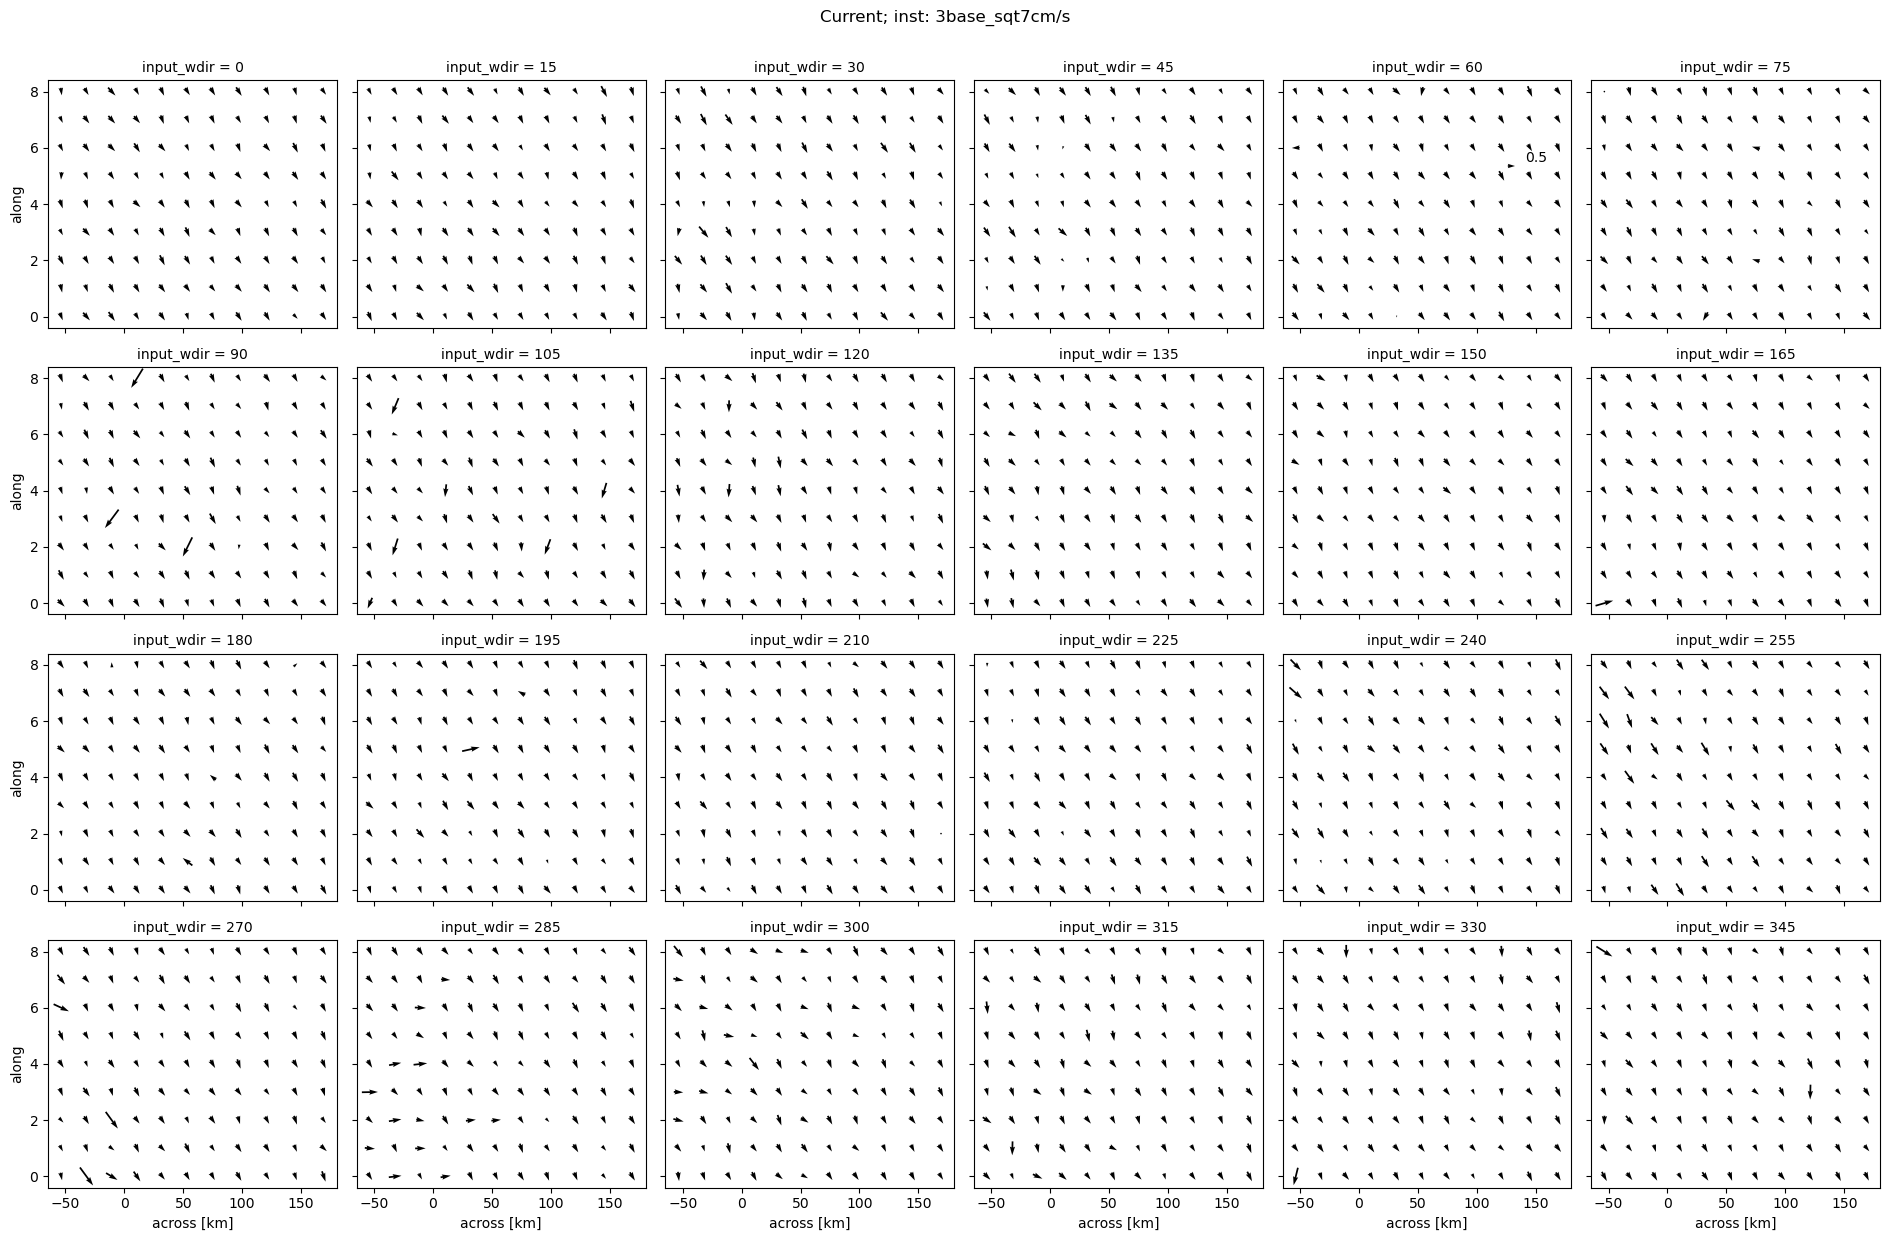

In [38]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 3base_sqt7cm/s')

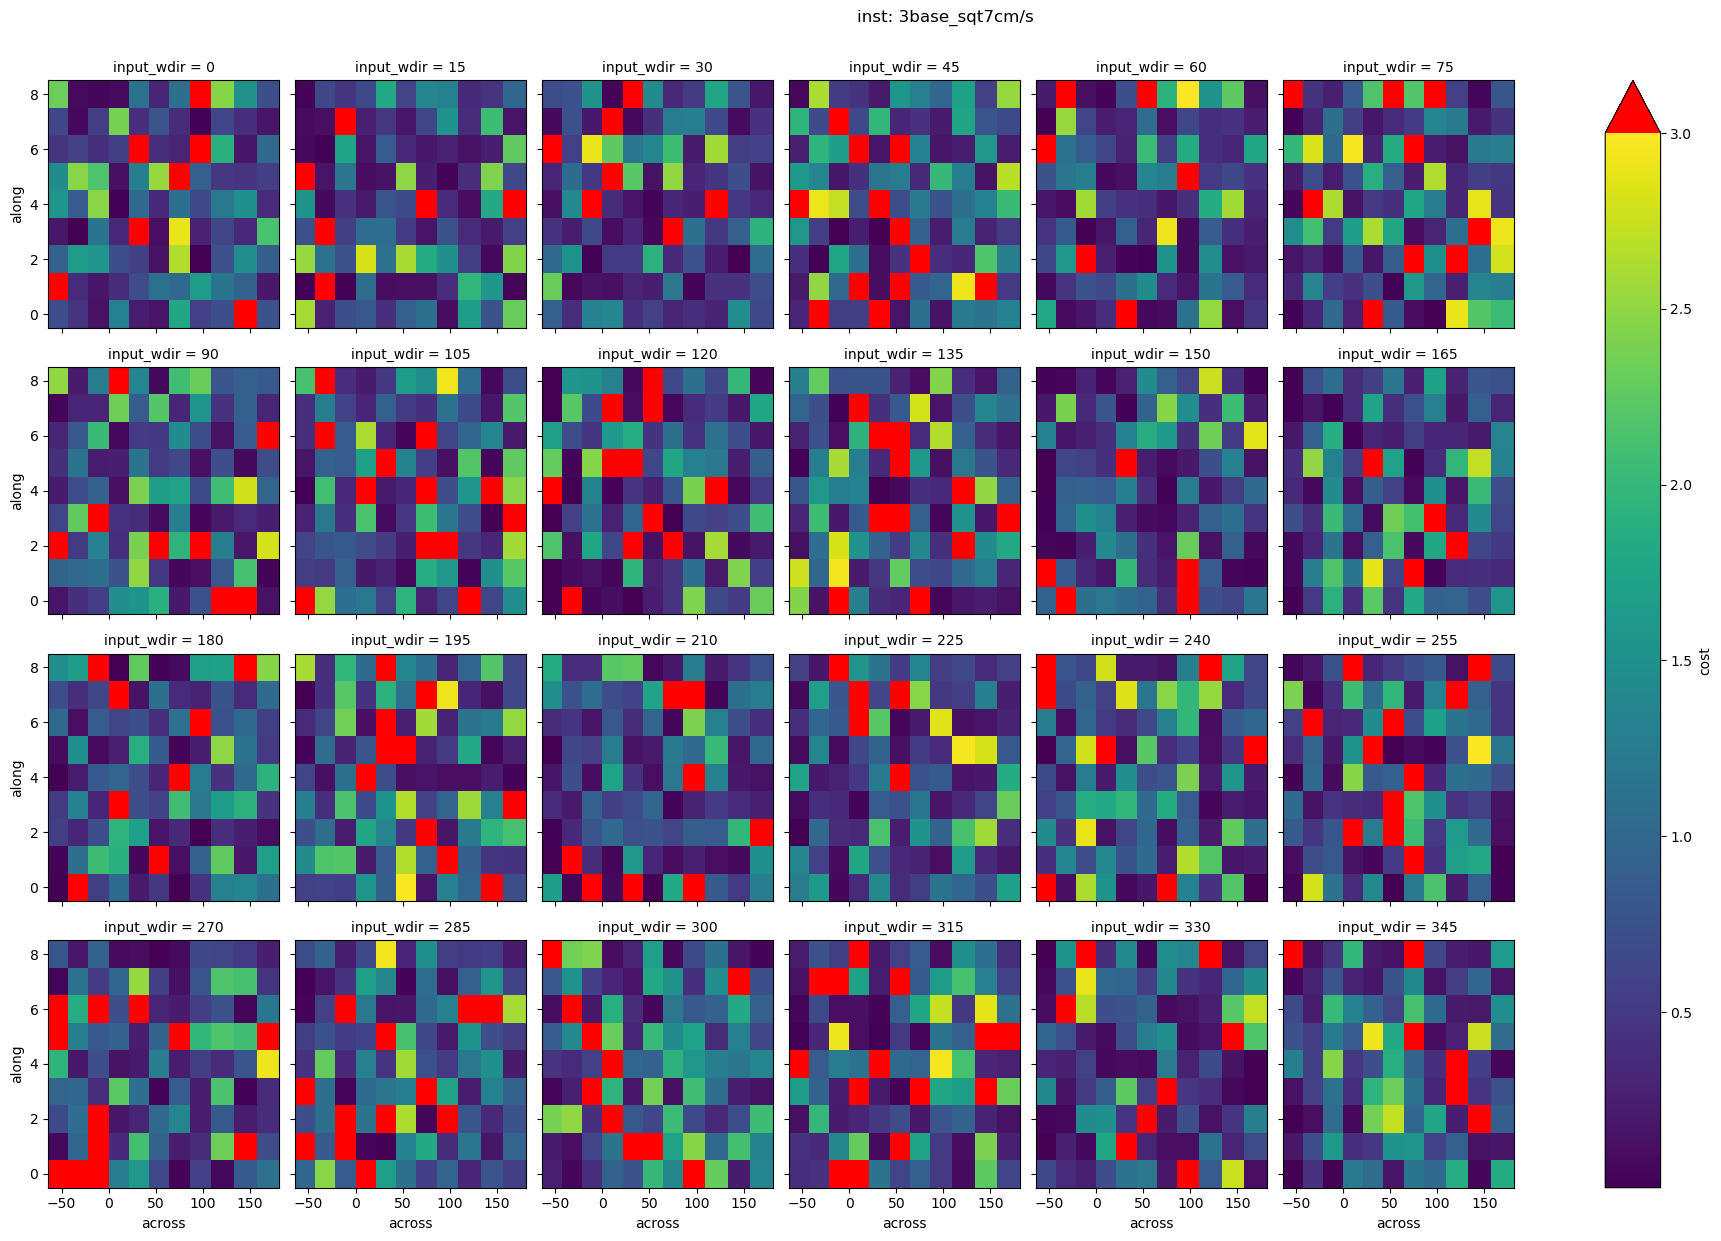

In [39]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=3, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

In [40]:
err = level2b - truth
err['flag'] = level2b.cost > 3

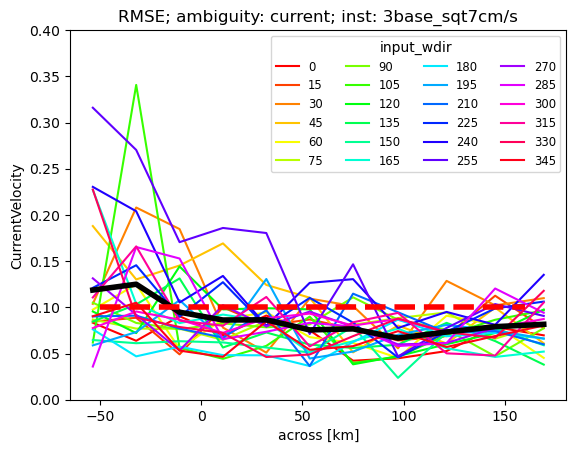

In [41]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

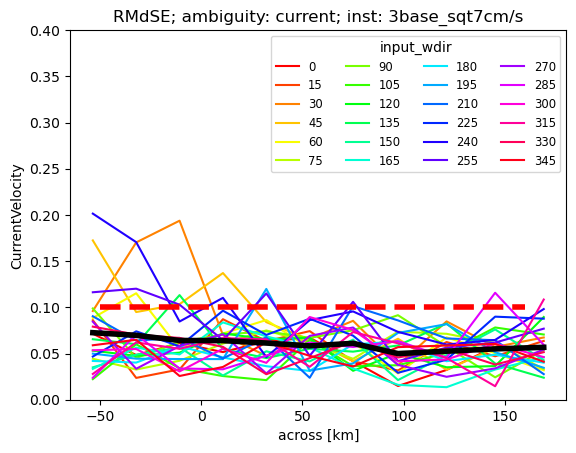

In [42]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# 6/ 3 beams (no HH, Squint 29°) otherwise same as baseline: 3sq29_3AC19_39: Sqt: 3%, 5cm/s; Mid: 4%, 40cm/s

In [43]:
nickname = '3sqt29'

In [44]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '3sq29_3AC19_39_011x009_SNKp03RSV05_MVNKp04RSV40_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [45]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [46]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [47]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 3, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -148.9 -116.2 -83.45 ... 135.3 162.0
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 55.04 55.04 ... 111.9
    Polarization         (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 23.23 23.23 ... 40.7
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3sq29_3AC19_39_011x_SNKp03RSV05_MVNKp04RSV4...
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3sq29_3AC19_39_011x009_SNKp03RSV05_MVNKp04RSV40...
    level1:   ../level1s/level1_3sq29_3AC19_39_011x009_SNKp03RSV05_MVNKp04RSV...

Text(0.5, 1.03, 'Current; inst: 3sqt29')

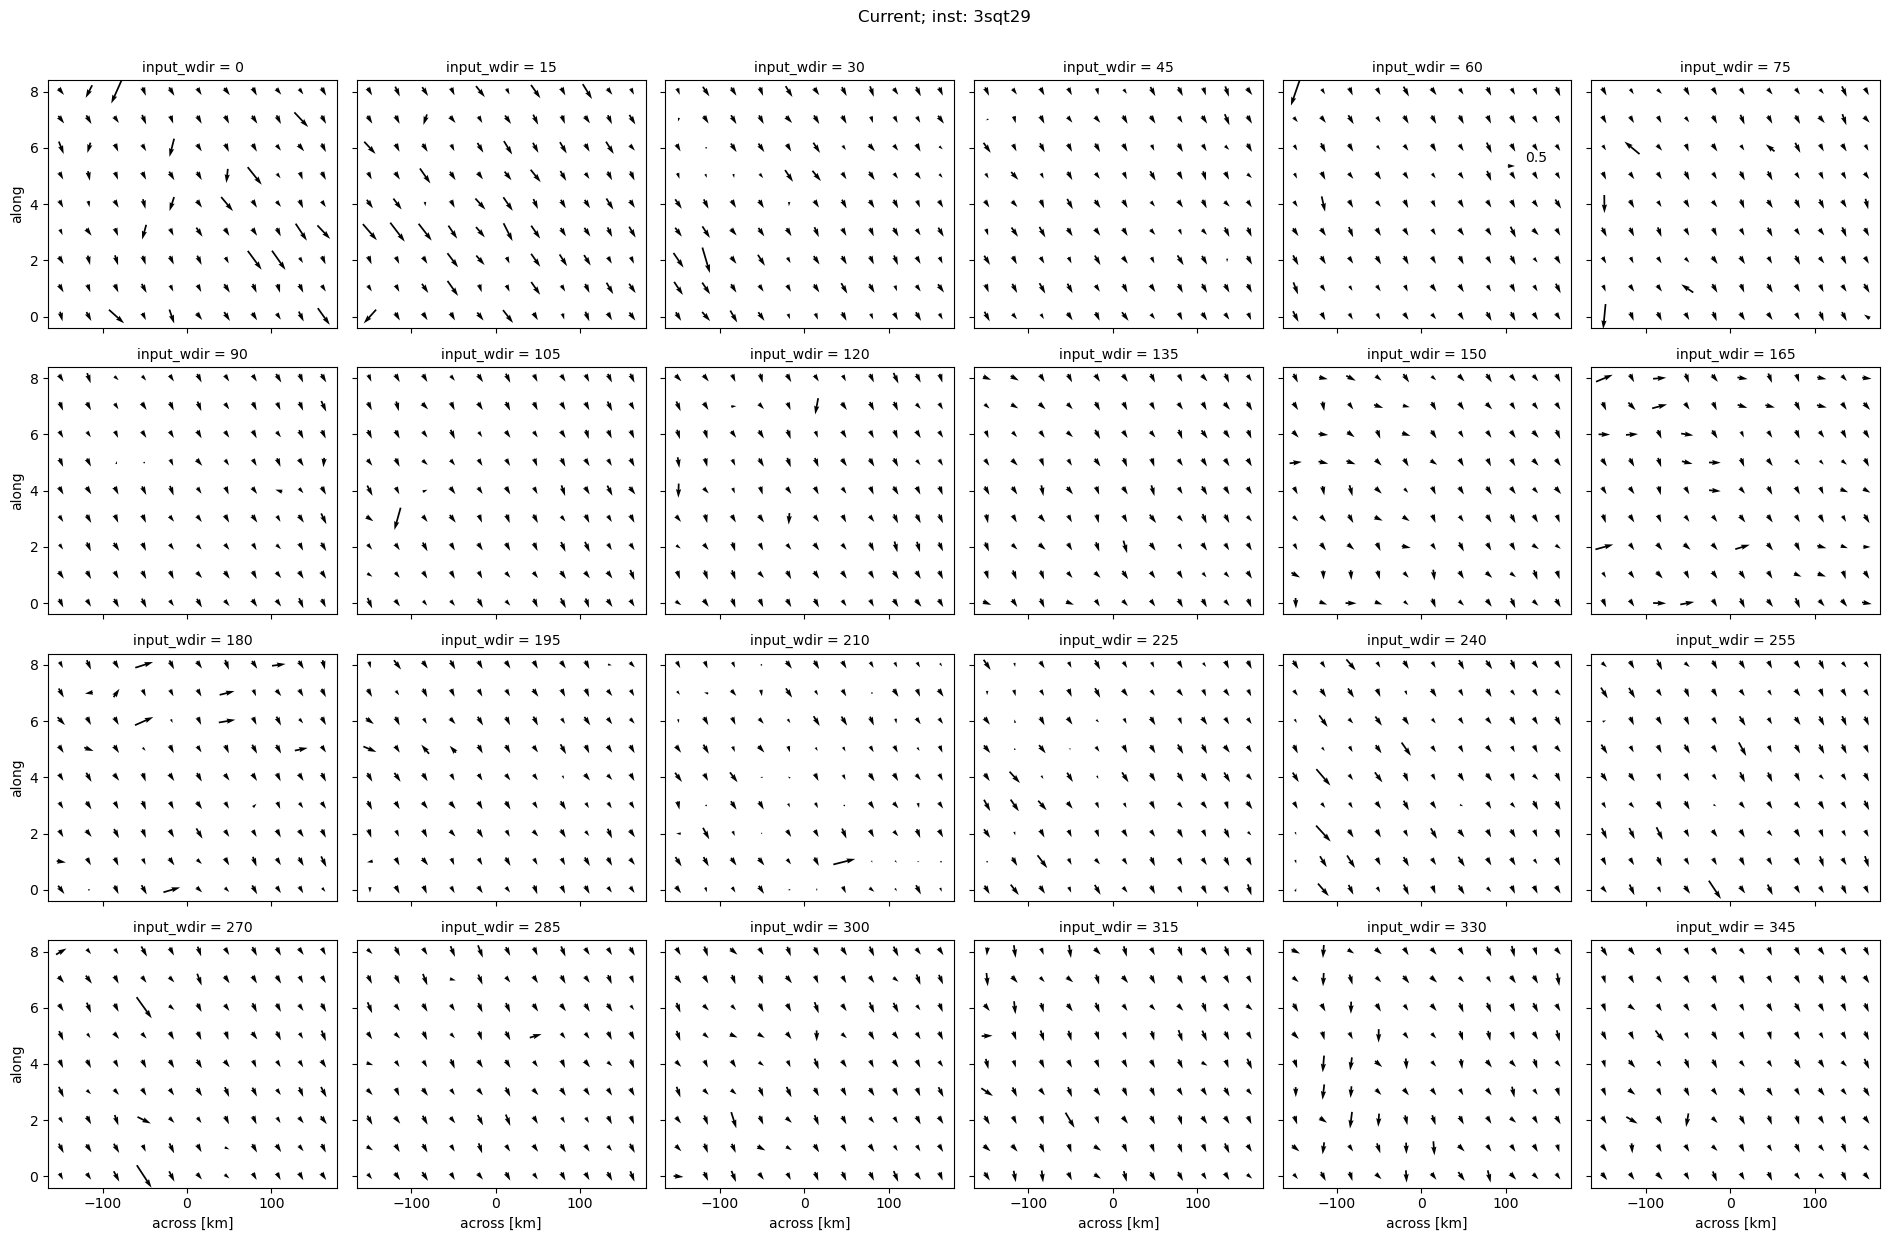

In [48]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 3sqt29')

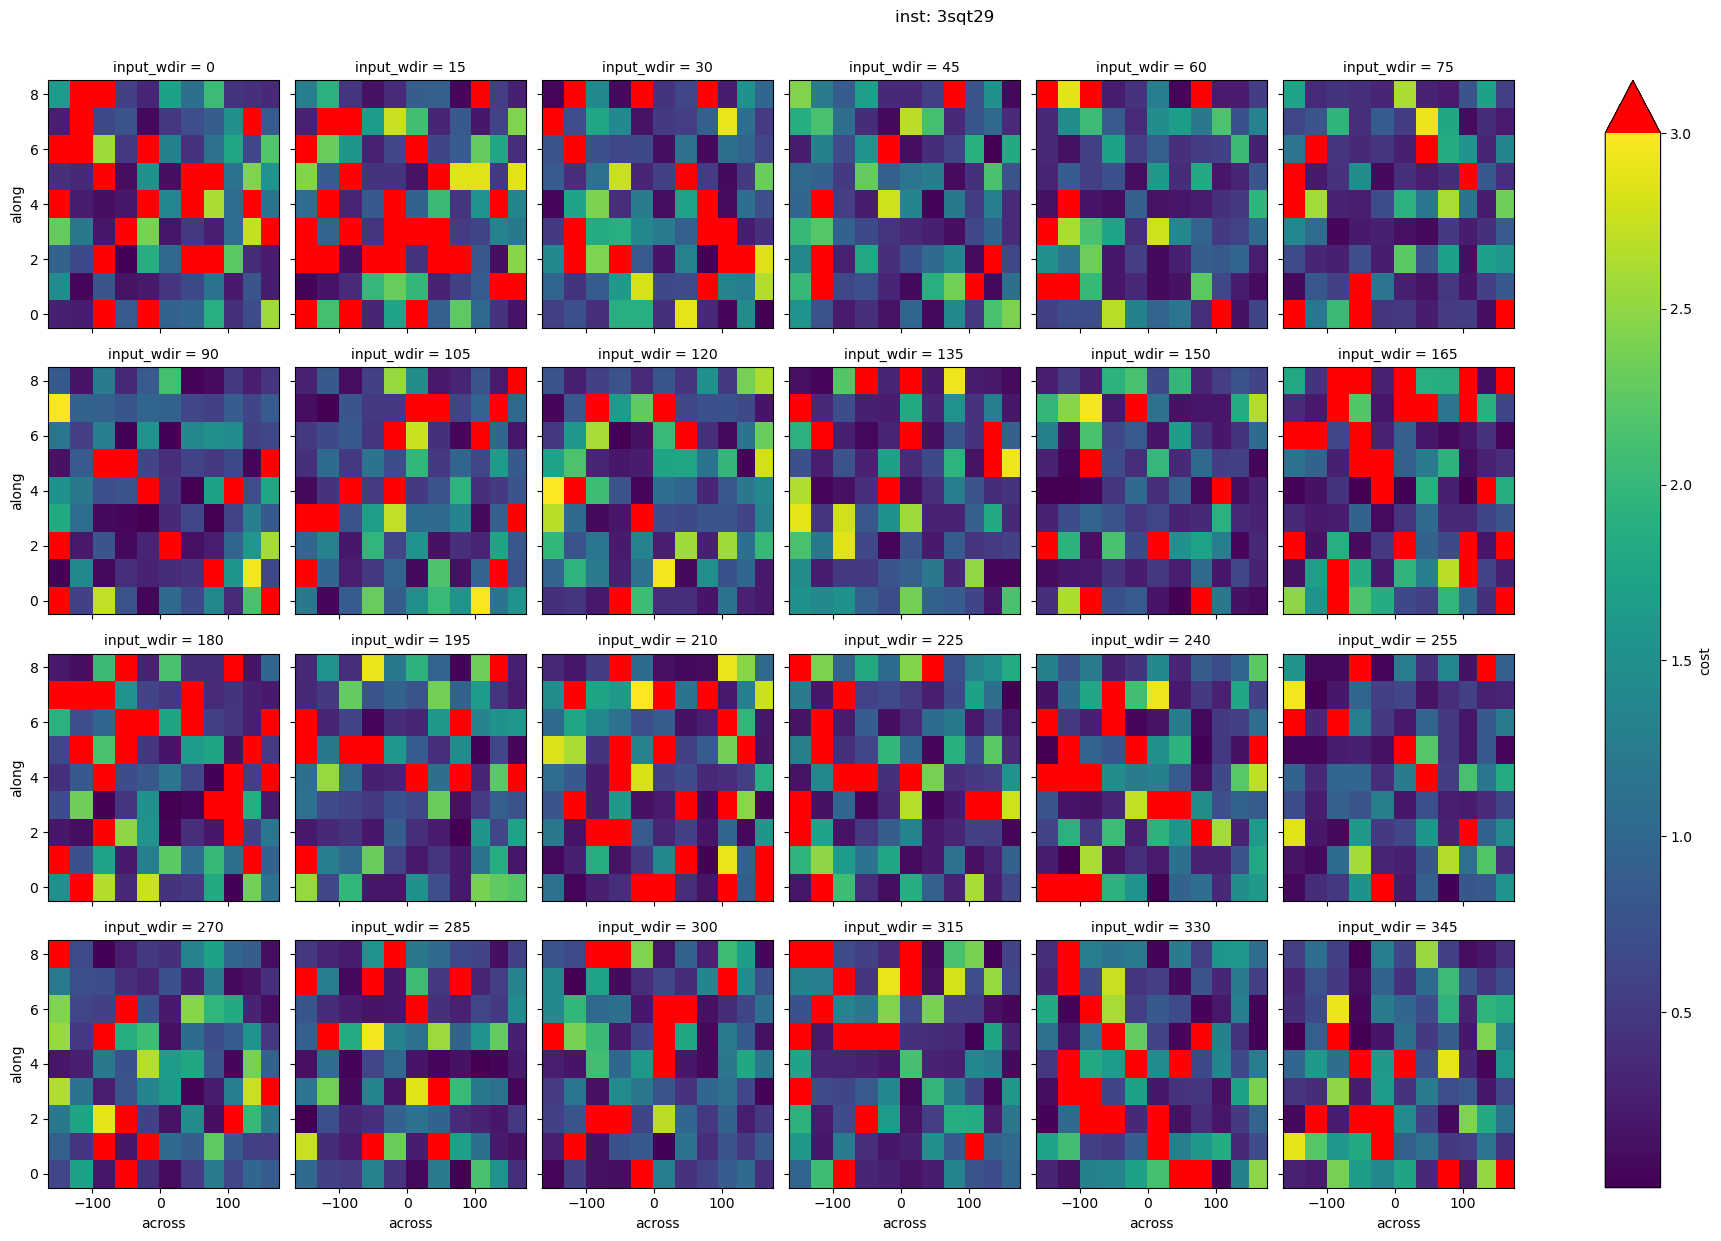

In [49]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=3, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

In [50]:
err = level2b - truth
err['flag'] = level2b.cost > 3

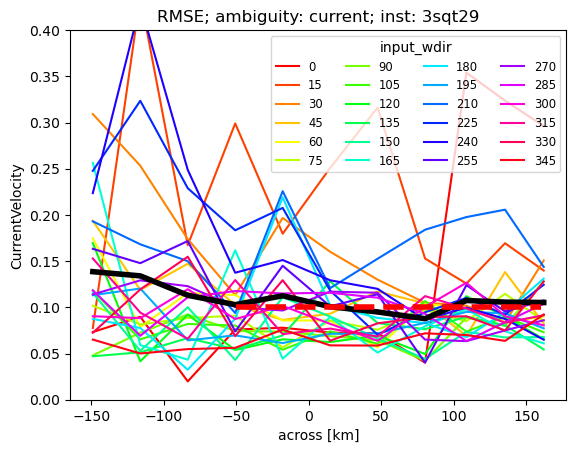

In [51]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

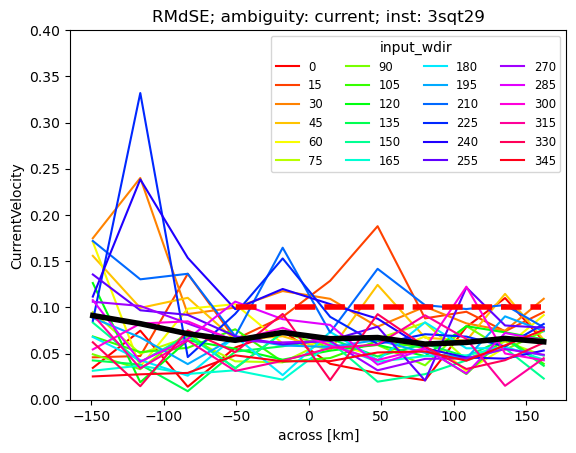

In [52]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# 7/ 2 beams (Squint 22°): 2sq22_3AC15_35: Sqt: 3%, 5cm/s;

In [53]:
nickname = '2sqt22'

In [54]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '2sq22_2AC15_35_011x009_SNKp03RSV05_W005_{:03.0f}_C0.6_150_N4DS_M12.nc'.format(inwdir)
    filename_l2 = 'level2_' + filename
    filename_truth = 'truth_' + filename
    level2_tmp[ii] = xr.open_dataset(SciReC_simu + 'level2s/' + filename_l2)
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(SciReC_simu + 'truths/' + filename_truth)
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [55]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [56]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [57]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:              (across: 11, along: 9, x_variables: 4, Observables: 2,
                          Antenna: 2, input_wdir: 24, ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce             <U4 'c_uv'
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 8
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'Aft'
    ...                   ...
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 64.82 64.82 ... 104.0
    Polarization         (Antenna) object 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
  * ambiguity_names      (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    x                    (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                 (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV             (ambiguity_names, input_wdir, across, along) float64 ...
    WindU                (ambiguity_names, input_wdir, across, along) float64 ...
    WindV                (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity      (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection     (ambiguity_names, input_wdir, across, along) float64 ...
    WindSpeed            (ambiguity_names, input_wdir, across, along) float64 ...
    WindDirection        (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_2sq22_2AC15_35_011x_SNKp03RSV05.nc
    geo:      ../geo/geo_011x009_W005_000_C0.6_150.nc
    truth:    ../truths/truth_2sq22_2AC15_35_011x009_SNKp03RSV05_W005_000_C0....
    level1:   ../level1s/level1_2sq22_2AC15_35_011x009_SNKp03RSV05_W005_000_C...

Text(0.5, 1.03, 'Current; inst: 2sqt22')

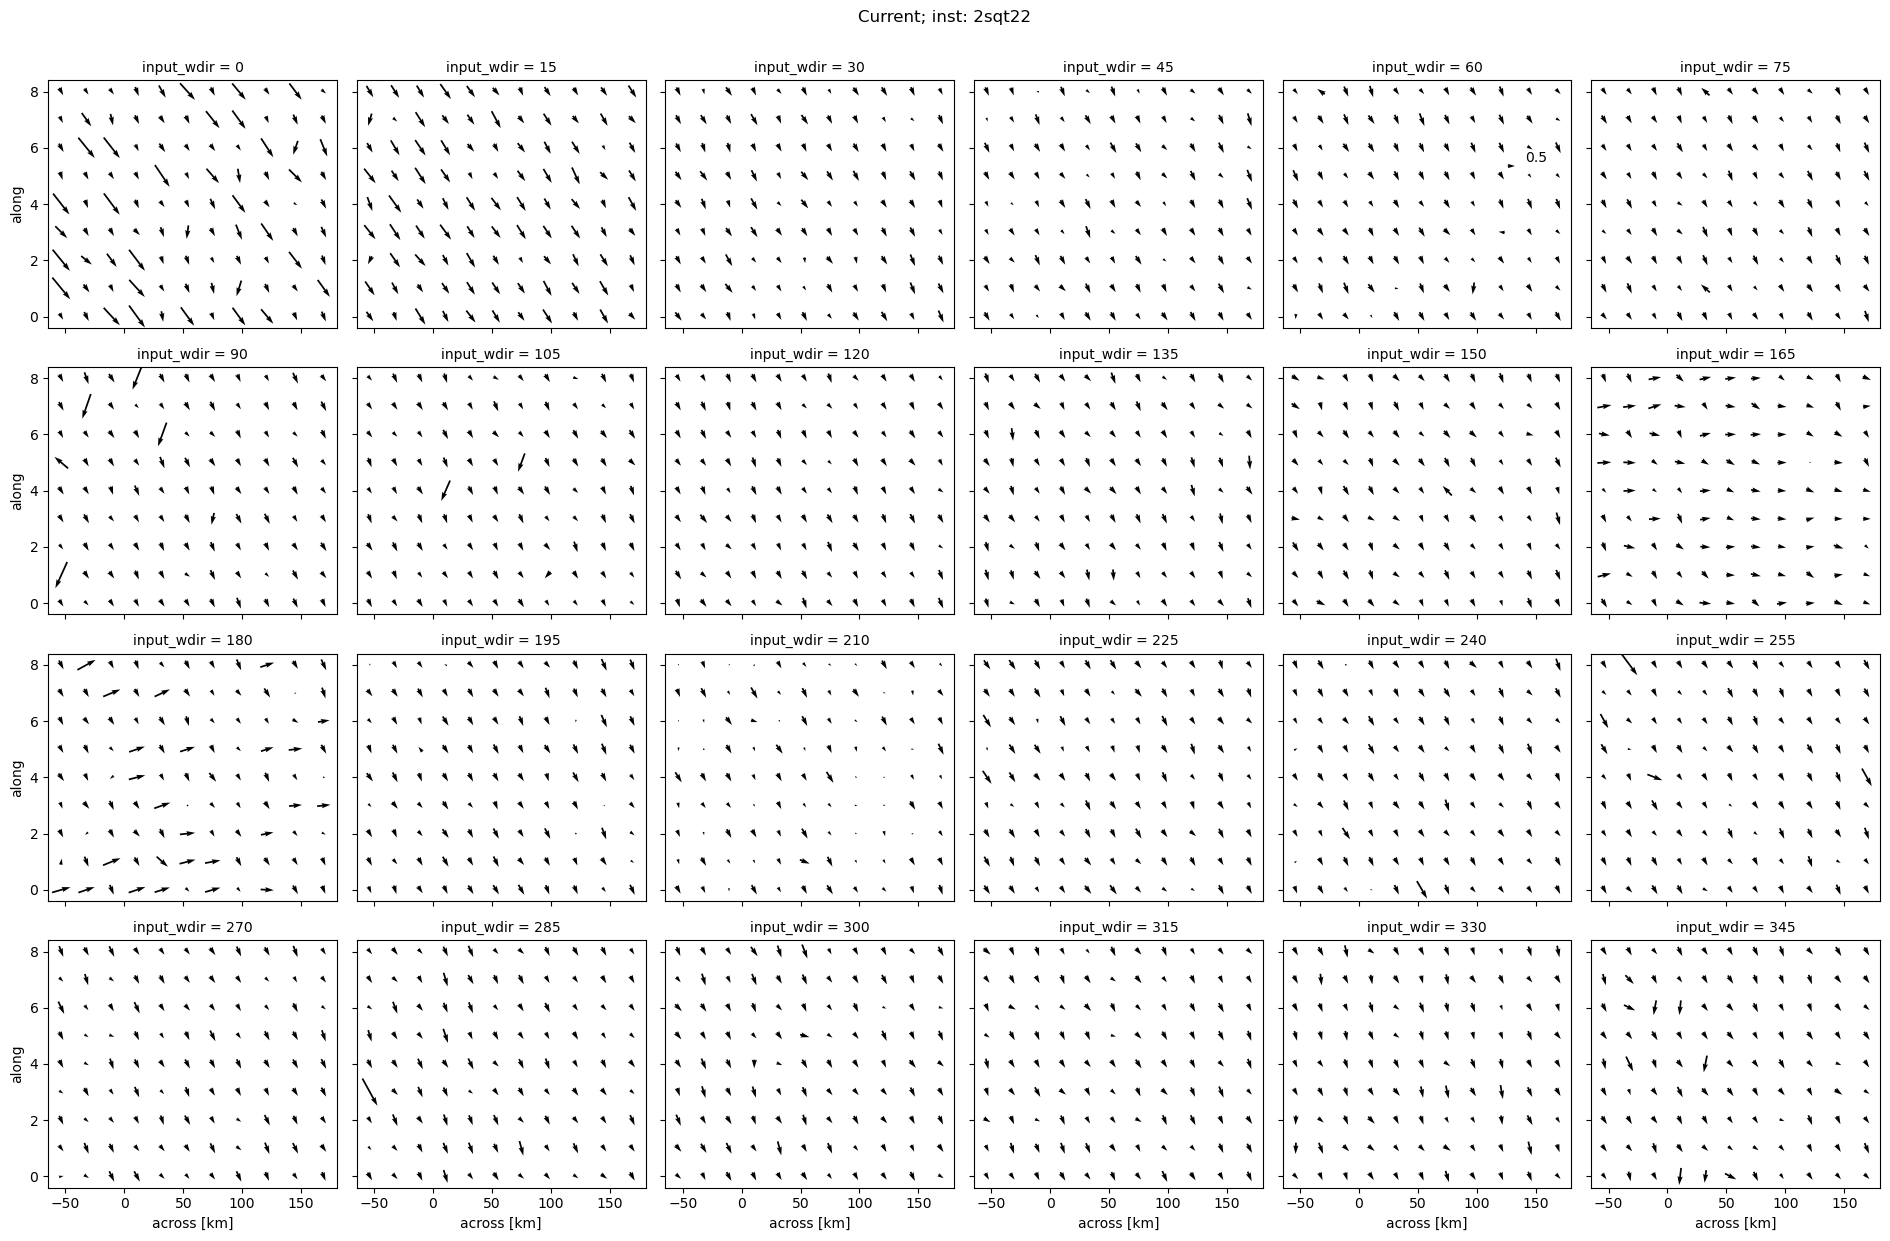

In [58]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 2sqt22')

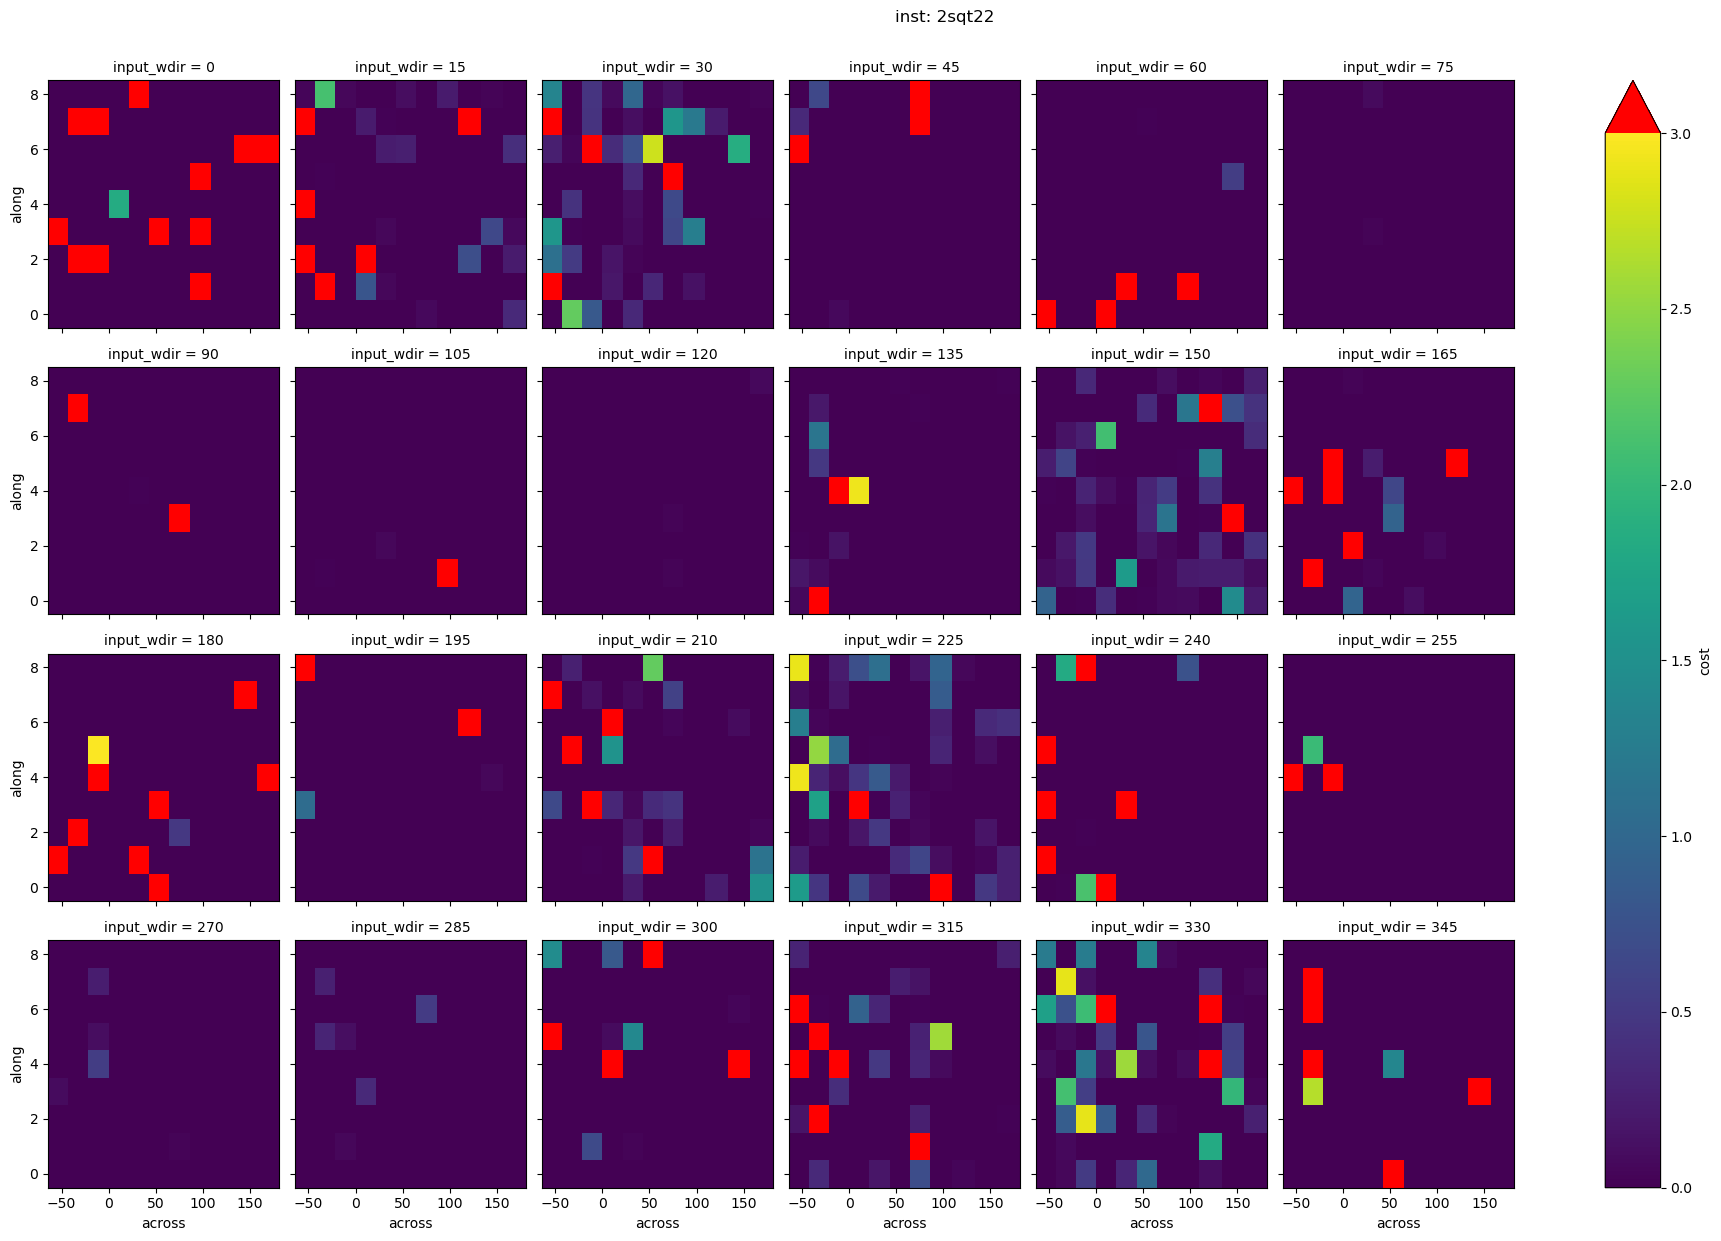

In [59]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=3, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

In [60]:
err = level2b - truth
err['flag'] = level2b.cost > 2

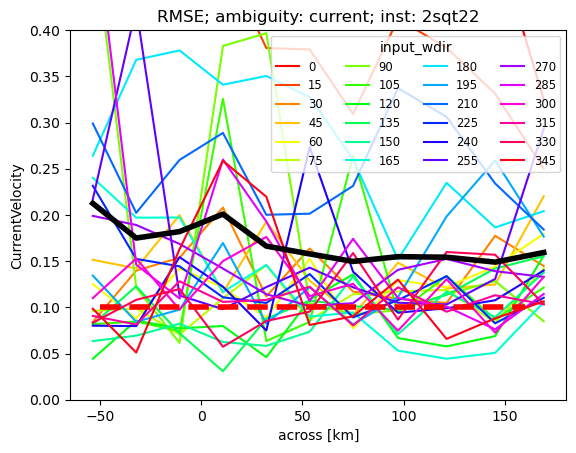

In [61]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

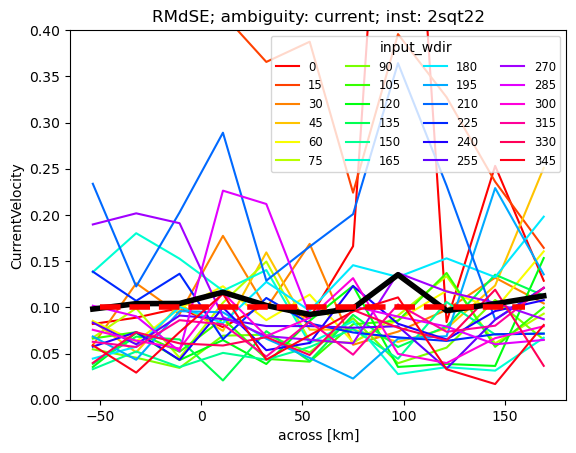

In [62]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')